# PROJECT INTRO
The project below is meant for breaking the infamous `SE-StereolithCypher`.

Since the cipher is written in a made-up alphabet, the precise numerical values of each letter are not known (*In english A=1, B=2, etc.*).<br>
This makes the cipher unbreakable, unless the decipherer was to run with every possible monoalphabetical substitution possible, giving us a 2^N algorithm complexity, making it virtually unusable.

There is however a very similar known fictional alphabet in which the `SE-MonolithCypher` is written and it does share similarities with the one we're dealing with in this project.

Based on this fact, I've made assumptions on which letter from the MonolithCypher corresponds to which letter in the StereolithCypher.<br>
These assumptions however are very loose, but they do narrow down the probable monoalphabetical substitutions, giving us way more affordable algorithm complexities.

The goal of this project is to try running a **custom-made vigenere decoder** (*and possibly other polyalphabetical decoders*) **for different monoalphabetical substitution tables** given as an input.

# PART 1: Creating language recognition tools
We start off the project by creating tools necessary for language recognition. These tools will allow for automated checking of whether the deciphered text is readable in a given language.
These tools work by comparing the deciphered-text letter frequencies with frequencies of the language provided. The more the frequencies match, the higher the chance for the deciphered text to have sense.
For these tools to be most accurate possible, a large text sample in the specified language has to be provided. I'll be using random novels found on the internet.

## Obtaining and formatting language sample files

### Obtaining language sample .txt files
We began the program by obtaining a relative path to all our .txt files in the given text_samples_folder, we also write down the laguage's alphabet for later use.

In [61]:
import os
text_samples_folder = 'BritishNovels'
ALPHABET = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

samples_folder_path = os.path.join(os.getcwd(), text_samples_folder)
sample_file_paths = [os.path.join(samples_folder_path, file_name) for file_name in os.listdir(samples_folder_path) if file_name.endswith('.txt')]

### Formatting language sample .txt files
In this step we are formatting the files - first by changing all their letters to upper case, then removing all non letter characters.<br>
We're also joining all the language sample files into one large string. This way we receive a gigantic sample of text in the given language.

In [62]:
#Formatting the sample_text_files
combined_text = []
for file_path in sample_file_paths:
    # Replace 'ISO-8859-1' with the actual encoding of the text files
    with open(file_path, 'r', encoding='ISO-8859-1') as file:
        upperCase_text = file.read().upper()
    cleaned_text = ''.join(char if char in ALPHABET else '' for char in upperCase_text)
    combined_text.append(cleaned_text)
combined_text = ''.join(combined_text)

## Obtaining n-gram frequencies
Here I present a function, which extracts a given n-gram frequency from the text.<br>
It's worth noting that it doesn't take into account n-gram's separated with a space.<br>
In case the argument dataDisplay is true the analytical data is displayed in a sorted manner (*note that the returned frequency array is not sorted and has empty fields for n-gram's that don't exist in the text*).

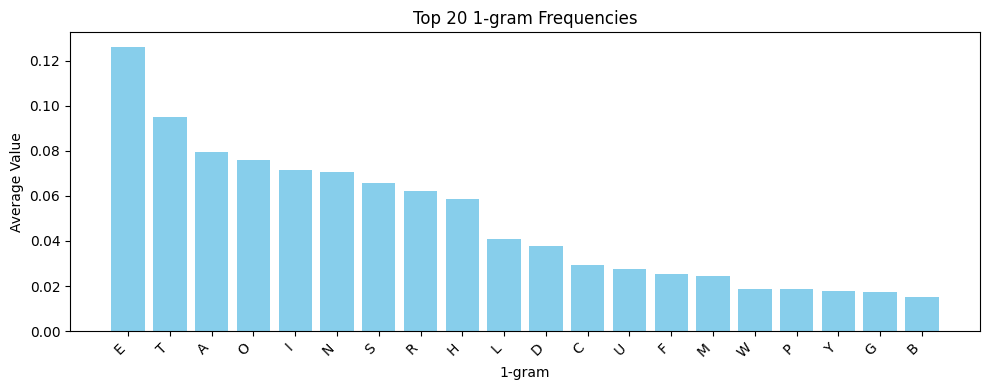

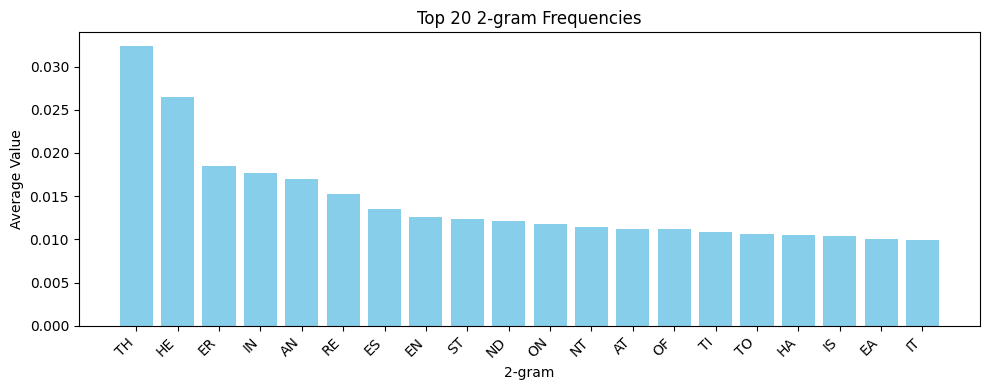

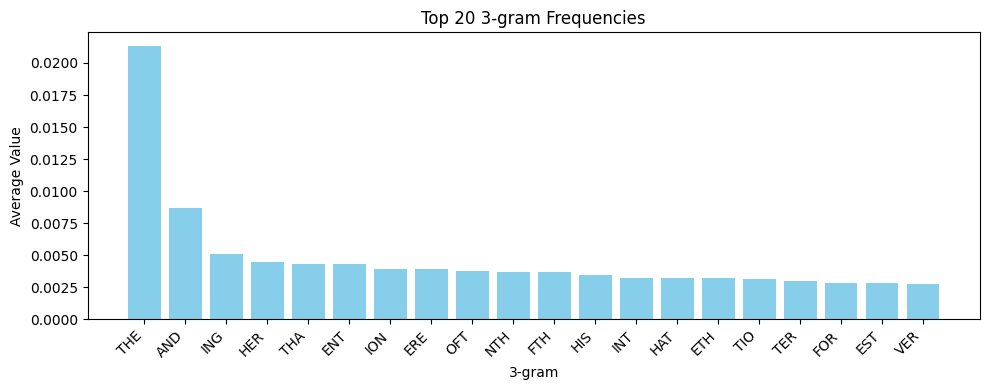

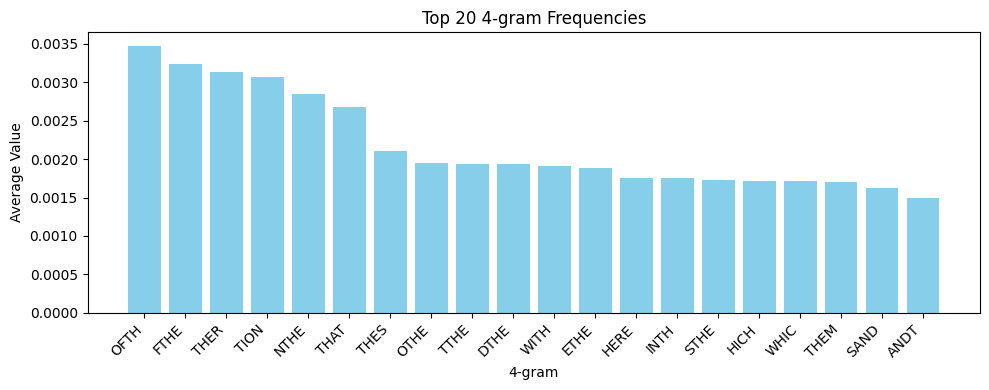

In [72]:
import matplotlib.pyplot as plt

def plot_top_ngram_frequencies(text, n, dataDisplay):

    if not text:
        print("Input text file is empty!")
        return None
    
    if len(text) - n - 1 <= 0:
        print("Text length is too short for n-gram calculation.")
        return None

    # Initializing the n-gram frequencies arrays
    ngram_frequencies_values = [0] * (len(ALPHABET) ** n)
    ngram_frequencies_strings = [''] * (len(ALPHABET) ** n)

    #Filling the arrays with n-gram's (each n-gram has an appropriate index calculated for it)
    for i in range(len(text) - n + 1):
        ngram_chars = text[i:i + n]
        x = sum(ALPHABET.index(char) * len(ALPHABET) ** (n - 1 - j) for j, char in enumerate(ngram_chars))
        ngram_frequencies_values[x] += 1
        ngram_frequencies_strings[x] = ngram_chars
            

    # Calculating the average frequencies of n-gram's
    average_ngram_values = [round(value / (len(text) - n - 1), 6) for value in ngram_frequencies_values]

    if dataDisplay:
        # Combining average values and n-gram strings into a list of tuples
        combined_ngram_data = [(avg, ngram_str) for avg, ngram_str in zip(average_ngram_values, ngram_frequencies_strings)]

        # Sorting the combined data based on average values in descending order
        sorted_ngram_data = sorted(combined_ngram_data, key=lambda x: x[0], reverse=True)

        # Extracting the data for plotting
        top_entries = sorted_ngram_data[:20]  # Taking the first 20 entries
        average_values, ngram_strings = zip(*top_entries)

        #Displaying the plot
        plt.figure(figsize=(10, 4))
        plt.bar(ngram_strings, average_values, color='skyblue')
        plt.xlabel(f'{n}-gram')
        plt.ylabel('Average Value')
        plt.title(f'Top 20 {n}-gram Frequencies')
        plt.xticks(rotation=45, ha='right')  # Rotating x-axis labels for better visibility
        plt.tight_layout()
        plt.show()

    return average_ngram_values

# Setting how many different n-gram's we want to test
ngram_count = 4
# Calling the function for sample texts 1, 2, 3, and 4-gram frequencies (obtaining reference frequencies)
ref_frequencies = [plot_top_ngram_frequencies(combined_text, i + 1, True) for i in range(ngram_count)]

## Creating a frequency comparator

### The Fitness function
Here I present a function which compares the frequencies of two n-gram's in order to determine whether they match. If the matching score is high enough, the text's are likely to be in the same language.

In [64]:
from math import log

def fitness(ref_ngram, test_ngram):
    result = 0
    items = 0
    for i in range(len(test_ngram)):
        if test_ngram[i] > 0:
            items += 1
            if i > len(ref_ngram) or ref_ngram[i] == 0:
                result += -15 # some large negative number
            else:
                result += log(ref_ngram[i])
    result = result / items
    return result

### The Fitness function test
It's important to run this function first with non-ciphered texts, in order to find the expected score for matching languages.

Below is a test program, which you can use to find and set the highest value for which the text language's match.

In [65]:
fitness_test_text = 'FitnessTest.txt'

#Formatting the text file
# Replace 'ISO-8859-1' with the actual encoding of the text files
with open(os.path.join(os.getcwd(), fitness_test_text), 'r', encoding='ISO-8859-1') as file:
    upperCase_text = file.read().upper()
fitness_test_text = ''.join(char if char in ALPHABET else '' for char in upperCase_text)

# Calling the function for sample texts 1, 2, 3, and 4-gram frequencies (obtaining test frequencies)
test_frequencies = [plot_top_ngram_frequencies(fitness_test_text, i + 1, False) for i in range(ngram_count)]

fitness_score = sum(fitness(ref_frequencies[i], test_frequencies[i]) for i in range(ngram_count)) / ngram_count

print("Fitness score: " + str(fitness_score))

#Setting the score sucess barrier ; For british it's about -7 ; For czech it's about
language_match_barrier = -7 

Fitness score: -7.260725924018134


# PART 2: Creating all ciphered text combinations
In this part we focus on creating a list of all the given monoalphabetical substitutions.

**The .txt file we input should be formatted in this specific manner:**<br>
First line: Ciphered text with subsitution list numbers in square brackets<br>
Each line after: \<SubstitutionListNumber\> = \<Letters to sibstute for separated with a comma and space\>

*Note that spaces are important and the numbers have to start from 1*

**Here's an example:**<br>
I [1]m th[2] [3][4][2] wh[3] k[4][2]cks!<br>
1 = A, D<br>
2 = C, E<br>
3 = T, G<br>
4 = P, H<br>

Do note that in the above examples we have 2^4 combinations! The more combinations we have, the longer the decoder will take to try breaking them all. The waiting times can get out of hand pretty quickly, so be careful with how many substitutions you want to try.

In [66]:
import re

#Function for creating the ciphered text and substitution list
def read_substitutions(fileName):
    substitutions = {}

    # Replace 'ISO-8859-1' with the actual encoding of the text files
    with open(os.path.join(os.getcwd(), fileName), 'r', encoding='ISO-8859-1') as file:   
        #Reading the ciphered text
        cipher = file.readline().rstrip().upper()

        #Creating substitutions list
        substitutions_line = file.readline().rstrip()
        while substitutions_line:
            index, options = substitutions_line.split(' = ')
            substitutions[int(index) - 1] = ''.join(options.split(', '))
            substitutions_line = file.readline().rstrip()

    return cipher, substitutions if cipher and substitutions else None

#Recursive function for generating all text variations based on the subsitution list
def get_variants(text, substitutions):
    matches = re.findall(r'\[(\d+)\]', text)
    #If there are no substitutions to be made return the text
    if not matches:
        return [text]
    else:
        #Counting how many text combination there will be 
        variant_count = 1
        for i in range(len(substitutions)):
            variant_count *= len(substitutions[i])

        #Creating all the possible substitution strings
        variants = [''] * (variant_count)
        period = variant_count
        for i in range(len(substitutions)):
            period = int(period / len(substitutions[i]))
            x = 0
            for j in range(int(variant_count / period)):
                for k in range(period):
                    variants[j * period + k] += substitutions[i][x]
                x = (x + 1) % len(substitutions[i])          

        #Substituting the numbers for appropriate char's in the previously made strings
        text_variants = [''] * (variant_count)
        for i in range(variant_count):
            for j in range(len(text)):
                if text[j] == '[':
                    text_variants[i] += variants[i][int(text[j + 1]) - 1]
                elif text[j] in ALPHABET or text[j].isspace():
                    text_variants[i] += text[j]

        return text_variants

#Function for removing all square brackets from the texts list
def format_variants(variants, displayData):
    if displayData:
        print("All possible variations:")
        
    #Removing square brackets from texts
    variants_without_brackets = []
    for variant in variants:
        formatted_variant = ''.join(char if char in ALPHABET or char.isspace() else '' for char in variant)

        if displayData:
            print(formatted_variant)
        variants_without_brackets.append(formatted_variant)

    #Counting space positions
    positions = []
    for i, char in enumerate(variants_without_brackets[0]):
        if char == ' ':
            positions.append(i)

    #Removing spaces from texts
    formated_variants = []
    for variant in variants:
        formatted_variant = ''.join(char if char in ALPHABET else '' for char in variant)
        formated_variants.append(formatted_variant)

    return positions, formated_variants

#A function for later use for inserting spaces back into the deciphered text
def insert_spaces(text, positions):
    for pos in positions:
        text = text[:pos] + ' ' + text[pos:]
    return text

cipher = 'Stereolith.txt'
ciphertext, substitutions = read_substitutions(cipher)
ciphertext_variants = get_variants(ciphertext, substitutions)
space_positions, ciphertext_variants = format_variants(ciphertext_variants, True)

All possible variations:
AMMD DBMM YLICTJM CIJ BAF DJM ZBRTZM EDJM
AMMD DBMM YLICTJM CIJ BAF DJM ZBOTZM EDJM
AMMD DBMM YLICTJM CIJ BAF DJM GBRTGM EDJM
AMMD DBMM YLICTJM CIJ BAF DJM GBOTGM EDJM
AMMD DBMM YLICTJM GIJ BAF DJM ZBRTZM EDJM
AMMD DBMM YLICTJM GIJ BAF DJM ZBOTZM EDJM
AMMD DBMM YLICTJM GIJ BAF DJM GBRTGM EDJM
AMMD DBMM YLICTJM GIJ BAF DJM GBOTGM EDJM
AMMD DBMM YLICTXM CIX BAF DXM ZBRTZM EDXM
AMMD DBMM YLICTXM CIX BAF DXM ZBOTZM EDXM
AMMD DBMM YLICTXM CIX BAF DXM GBRTGM EDXM
AMMD DBMM YLICTXM CIX BAF DXM GBOTGM EDXM
AMMD DBMM YLICTXM GIX BAF DXM ZBRTZM EDXM
AMMD DBMM YLICTXM GIX BAF DXM ZBOTZM EDXM
AMMD DBMM YLICTXM GIX BAF DXM GBRTGM EDXM
AMMD DBMM YLICTXM GIX BAF DXM GBOTGM EDXM
AMMD DBMM PLICTJM CIJ BAF DJM ZBRTZM EDJM
AMMD DBMM PLICTJM CIJ BAF DJM ZBOTZM EDJM
AMMD DBMM PLICTJM CIJ BAF DJM GBRTGM EDJM
AMMD DBMM PLICTJM CIJ BAF DJM GBOTGM EDJM
AMMD DBMM PLICTJM GIJ BAF DJM ZBRTZM EDJM
AMMD DBMM PLICTJM GIJ BAF DJM ZBOTZM EDJM
AMMD DBMM PLICTJM GIJ BAF DJM GBRTGM EDJM
AMMD DBMM

# PART 3: (Optional) Finding the key length
In order to optimize the code and have it run faster, instead of bruteforcing attacks with all key lengths in range, we can use Kasisky method to analyticaly determine most probable key lengths and have the program only try to decipher with those.

In [67]:
def index_of_coincidence(text):
    counts = [0] * 26
    total = 0
    for char in text:
        counts[ALPHABET.index(char)] += 1
    numer = sum(counts[i] * (counts[i] - 1) for i in range(26))
    total = sum(counts)
    return 26 * numer / (total * (total - 1))

def find_period(ciphertext):
    found = False
    period = 0
    while not found:
        period += 1
        slices = [''] * period
        for i in range(len(ciphertext)):
            slices[i % period] += ciphertext[i]
        total_ioc = sum(index_of_coincidence(slice) for slice in slices)
        average_ioc = total_ioc / period
        if average_ioc > 1.6:
            found = True
    return period

# PART 4: BREAKING THE CYPHER!

In [100]:
def encrypt(plaintext, key):
    ciphertext = ''
    for i in range(len(plaintext)):
        p = ALPHABET.index(plaintext[i])
        k = ALPHABET.index(key[i % len(key)])
        c = (p + k) % 26
        ciphertext += ALPHABET[c]

    return ciphertext

def decrypt(ciphertext, key):
    plaintext = ''
    for i in range(len(ciphertext)):
        p = ALPHABET.index(ciphertext[i])
        k = ALPHABET.index(key[i % len(key)])
        c = (p - k) % 26
        plaintext += ALPHABET[c]
    return plaintext

## VARIATIONAL METHOD

In [ ]:
from random import randrange
from tqdm import tqdm

def variational_method_decrypt_single(ciphertext, key_length, min_fit):
    #Calculating current fit for bar display purposes
    res_frequencies = [plot_top_ngram_frequencies(ciphertext, j + 1, False) for j in range(ngram_count)]
    first_fit = sum(fitness(ref_frequencies[j], res_frequencies[j]) for j in range(ngram_count)) / ngram_count
    current_variant_bar = tqdm(total=(min_fit-first_fit), desc='Current variant decryption', position=0)

    max_consecutive_no_improvement = 1000
    consecutive_no_improvement = 0

    key = ['A'] * key_length
    fit = -99
    while fit < min_fit and consecutive_no_improvement < max_consecutive_no_improvement:
        K = key[:]
        x = randrange(key_length)
        for i in range(26):
            K[x] = ALPHABET[i]
            pt = decrypt(ciphertext, K)
            res_frequencies = [plot_top_ngram_frequencies(pt, j + 1, False) for j in range(ngram_count)]
            F = sum(fitness(ref_frequencies[j], res_frequencies[j]) for j in range(ngram_count)) / ngram_count
            if (F > fit):
                key = K[:]
                fit = F
                current_variant_bar.update(fit - first_fit - current_variant_bar.n)
                consecutive_no_improvement = 0
                break
            else:
                consecutive_no_improvement += 1
                continue

    #DEBUG
    print(ciphertext + ", " + ''.join(key))

    current_variant_bar.close()    
    return decrypt(ciphertext, key)

def variational_method_decrypt_all(ciphertext_variants):
    deciphered_texts = []
    all_variant_bar = tqdm(total=len(ciphertext_variants), desc='Entire program progression', position=0)
    for variant in ciphertext_variants:
        key_length = 5#find_period(variant)
        if key_length > 1:
            plain_text = variational_method_decrypt_single(variant, key_length, -8)
            print(plain_text)
            deciphered_texts.append(plain_text)
        all_variant_bar.update(1)

    all_variant_bar.close()   
    return deciphered_texts

deciphered_texts = variational_method_decrypt_all(ciphertext_variants)
print(deciphered_texts)

## CRIB

In [132]:
from tqdm import tqdm

def using_crib_decrypt_single(ciphertext, crib):
    key_candidates = []

    # Loop over the ciphertext and compare it with the crib
    for i in range(len(ciphertext) - len(crib) + 1):  # Adjusted range to ensure full coverage
        candidate_key = ''
        try:
            decrypted_texts = {}
            for j in range(len(crib)):
                # Guessing the key part by assuming crib encrypted with key
                candidate_key += ALPHABET[(ALPHABET.index(ciphertext[i + j]) - ALPHABET.index(crib[j])) % 26]
                if(len(candidate_key) > 0):
                    decrypted_text = decrypt(ciphertext, candidate_key)
                    res_frequencies = [plot_top_ngram_frequencies(decrypted_text, j + 1, False) for j in range(2)]
                    fitness_score = sum(fitness(ref_frequencies[j], res_frequencies[j]) for j in range(2)) / 2
                    print(str(fitness_score) + ", " + decrypted_text)
            key_candidates.append(candidate_key)
        except ValueError:
            # Crib not found in this portion of the ciphertext
            pass

    return key_candidates

def using_crib_decrypt_all(ciphertext_variants, crib):
    key_candidates_all_variants = []
    all_variant_bar = tqdm(total=len(ciphertext_variants), desc='Crib attack progression', position=0)
    
    for variant in ciphertext_variants:
        key_candidates = using_crib_decrypt_single(variant, crib)
        key_candidates_all_variants.append(key_candidates)
        all_variant_bar.update(1)

    all_variant_bar.close()   
    return key_candidates_all_variants

crib = "SPACE"
key_candidates_all_variants = using_crib_decrypt_all(ciphertext_variants, crib)


Crib attack progression:   1%|          | 2/192 [00:00<00:13, 13.83it/s]

-6.093853542724912, SEEVVTEEQDAULBEUABTSXVBERTJLREWVBE
-6.107186695581523, SPEGVEEPQOAFLMEFAMTDXGBPREJWRPWGBP
-6.002886890445967, SPAVGPEPMDLQLMAULXTDTVMAREFLCAWGXE
-6.2259061523237325, SPACVEALQOWBLMABAMPZXGXLREFSRPSCBP
-5.754695102312937, SPACETPAXMAFHINULXABXGXLATUHYNWGXL
-6.543562700857205, GSSJJHSSEROIZPSIOPHGLJPSFHXZFSKJPS
-6.118434594172829, GPSGJESPEOOFZMSFOMHDLGPPFEXWFPKGPP
-7.088771970030704, GPJJGYSPVRLZZMJILGHDCJMJFEOZCJKGGS
-6.738012906342695, GPJCJEJLEOFBZMJBOMYZLGGLFEOSFPBCPP
-6.611940796367591, GPJCGHPJXOOFQIPILGADLGGLCHUQYPKGGL
-6.543562700857205, GSSJJHSSEROIZPSIOPHGLJPSFHXZFSKJPS
-6.548262231828173, GYSPJNSYEXOOZVSOOVHMLPPYFNXFFYKPPY
-7.091589416778454, GYJJPYSYVRUZZVJIUGHMCJVJFNOZLJKPGS
-6.4547051445970425, GYJEJNJNEXFDZVJDOVYBLPGNFNOUFYBEPY
-6.50279343298268, GYJEVHYJZDOOQKEIUGCSLPGNRHDQAEKPGN
-6.368141070949579, PBBSSQBBNAXRIYBRXYQPUSYBOQGIOBTSYB
-6.299137905483429, PYBPSNBYNXXOIVBOXVQMUPYYONGFOYTPYY
-5.720276070141169, PYLSPABYXAUBIVLRUIQMESVLONQILLTPIB
-5.970033

Crib attack progression:   3%|▎         | 6/192 [00:00<00:12, 14.88it/s]

-6.071535025436759, SEEVVTEEQDAULBEYABTSXVBERTJLREWVBE
-6.2088396234765595, SPEGVEEPQOAFLMEJAMTDXGBPREJWRPWGBP
-6.033746809508771, SPAVGPEPMDLQLMAYLXTDTVMAREFLCAWGXE
-6.220909310621581, SPACVEALQOWBLMAFAMPZXGXLREFSRPSCBP
-5.774124392698045, SPACETPAXMAFHINYLXABXGXLATUHYNWGXL
-6.562482232424417, GSSJJHSSEROIZPSMOPHGLJPSFHXZFSKJPS
-6.204749231562067, GPSGJESPEOOFZMSJOMHDLGPPFEXWFPKGPP
-7.160570943801284, GPJJGYSPVRLZZMJMLGHDCJMJFEOZCJKGGS
-6.704763449017598, GPJCJEJLEOFBZMJFOMYZLGGLFEOSFPBCPP
-6.7155252266221535, GPJCGHPJXOOFQIPMLGADLGGLCHUQYPKGGL
-6.562482232424417, GSSJJHSSEROIZPSMOPHGLJPSFHXZFSKJPS
-6.49042533401339, GYSPJNSYEXOOZVSSOVHMLPPYFNXFFYKPPY
-7.152371368940431, GYJJPYSYVRUZZVJMUGHMCJVJFNOZLJKPGS
-6.423700245970272, GYJEJNJNEXFDZVJHOVYBLPGNFNOUFYBEPY
-6.501084802256543, GYJEVHYJZDOOQKEMUGCSLPGNRHDQAEKPGN
-6.489563500015285, PBBSSQBBNAXRIYBVXYQPUSYBOQGIOBTSYB
-6.380888987397578, PYBPSNBYNXXOIVBSXVQMUPYYONGFOYTPYY
-5.8021802072334925, PYLSPABYXAUBIVLVUIQMESVLONQILLTPIB
-6.01817

Crib attack progression:   5%|▌         | 10/192 [00:00<00:12, 15.11it/s]

-6.471105209653428, HTKMYITKHGPJRSHNPHKVMKHVBIVRPHLKHV
-6.0669785206538815, KWWNNLWWIVSMDTWQSTLKPNTWQLYDQWONTW
-7.129198372816994, KZWQNOWZIYSPDWWTSWLNPQTZQOYGQZOQTZ
-7.522009199190509, KZTNQIWZFVVJDWTQVQLNMNWTQOVDTTOQQW
-6.9062912409458646, KZTWNOTFIYPVDWTZSWITPQQFQOVMQZLWTZ
-6.5643407802962574, KZTWVLZTRDSPACEQVQUSPQQFYLBAZEOQQF
-6.761114748680022, QCCTTRCCOBYSJZCWYZRQVTZCWREJWCUTZC
-6.771086059398717, QICZTXCIOHYYJFCCYFRWVZZIWXEPWIUZZI
-6.377795937887729, QIDTZSCIPBETJFDWEARWWTFDWXFJCDUZAC
-7.035016748814857, QIDTTXDCOHZSJFDWYFSQVZACWXFJWIVTZI
-6.393103094824671, QIDTBRIDOJYYKZKWEARYVZACERKKWKUZAC
-5.513983135909439, ZLLCCALLXKHBSILFHIAZECILFANSFLDCIL
-6.138528696196825, ZSLJCHLSXRHISPLMHPAGEJISFHNZFSDJIS
-6.434635676184415, ZSACJPLSMKOQSPAFOXAGTCPAFHCSMADJXL
-6.135178596091832, ZSAZCHAIXRWYSPACHPPWEJXIFHCPFSSZIS
-6.023416479607909, ZSAZZASAUHHIHFIFOXXWEJXICAUHCIDJXI
-6.88602160669231, JVVMMKVVHURLCSVPRSKJOMSVPKXCPVNMSV
-6.4037420700846255, JPVGMEVPHORFCMVJRMKDOGSPPEXWPPNGSP
-6.6468

Crib attack progression:   7%|▋         | 13/192 [00:20<06:02,  2.02s/it]

-5.469437901112076, NYPTBOYPOJVOWNKPUARYSPACEODWWKRPAC
-6.627965786348936, PBBSSQBBNAXRIMBRXMQPUSMBVQGIVBTSMB
-6.042956870777902, PEBVSTBENDXUIPBUXPQSUVMEVTGLVETVME
-5.72342941836417, PEASVPBEMAAQIPARALQSTSPAVTFIYATVLB
-5.891624469754271, PEAZSTAINDWYIPAYXPPWUVLIVTFPVESZME
-6.839238454799391, PEAZGQEAUOXUHTPRALXDUVLIJQJHCPTVLI
-6.476785101907678, VHHYYWHHTGDXOSHXDSWVAYSHBWMOBHZYSH
-5.92166379562563, VPHGYEHPTODFOAHFDAWDAGSPBEMWBPZGSP
-6.726363816249847, VPGYGVHPSGLWOAGXLRWDZYAGBELOJGZGRH
-5.37997173229885, VPGEYEGNTOCDOAGDDAVBAGRNBELUBPYESP
-6.6889570547798165, VPGEQWPGZYDFNYZXLRCNAGRNTWUNHZZGRN
-6.486100106058087, GSSJJHSSEROIZDSIODHGLJDSMHXZMSKJDS
-6.940355239655432, GVSMJKSVEUOLZGSLOGHJLMDVMKXCMVKMDV
-7.075276039305711, GVLJMASVXRRBZGLIRWHJEJGLMKQZPLKMWS
-6.907538081659605, GVLOJKLXEUHNZGLNOGALLMWXMKQEMVDODV
-6.275956044947044, GVLOOHVLJWOLSIXIRWMLLMWXRHASRXKMWX
-6.578803369818775, MYYPPNYYKXUOFJYOUJNMRPJYSNDFSYQPJY
-6.138955779939311, MAYRPPYAKZUQFLYQULNORRJASPDHSAQRJA
-6.147240260

Crib attack progression:   8%|▊         | 16/192 [00:21<06:53,  2.35s/it]

-5.772169985631007, SEEVVTEEQDAULPEYAPTSXVPERTGLREWVPE
-6.025773368158413, SPEGVEEPQOAFLAEJAATDXGPPREGWRPWGPP
-5.507148991604971, SPAVGPEPMDLQLAAYLLTDTVAARECLCAWGLE
-5.926669437185051, SPACVEALQOWBLAAFAAPZXGLLRECSRPSCPP
-5.4179735851787125, SPACETPAXMAFHWNYLLABXGLLATRHYNWGLL
-6.213761903666982, GSSJJHSSEROIZDSMODHGLJDSFHUZFSKJDS
-5.975335531545625, GPSGJESPEOOFZASJOAHDLGDPFEUWFPKGDP
-6.99460680101937, GPJJGYSPVRLZZAJMLUHDCJAJFELZCJKGUS
-6.444080321287087, GPJCJEJLEOFBZAJFOAYZLGULFELSFPBCDP
-6.658133970238333, GPJCGHPJXOOFQWPMLUADLGULCHRQYPKGUL
-6.213761903666982, GSSJJHSSEROIZDSMODHGLJDSFHUZFSKJDS
-6.477640923624198, GYSPJNSYEXOOZJSSOJHMLPDYFNUFFYKPDY
-7.16533841009932, GYJJPYSYVRUZZJJMUUHMCJJJFNLZLJKPUS
-6.481644107343124, GYJEJNJNEXFDZJJHOJYBLPUNFNLUFYBEDY
-6.394779661817747, GYJEVHYJZDOOQYEMUUCSLPUNRHAQAEKPUN
-6.322336312450906, PBBSSQBBNAXRIMBVXMQPUSMBOQDIOBTSMB
-6.499231647786469, PYBPSNBYNXXOIJBSXJQMUPMYONDFOYTPMY
-6.019978045396427, PYLSPABYXAUBIJLVUWQMESJLONNILLTPWB
-6.10889786

Crib attack progression:   9%|▉         | 18/192 [00:21<04:28,  1.54s/it]

-5.818540174467556, SEEVVTEEHDAULBEUABTSXVBERTJLREWVBE
-5.724835259217906, SPEGVEEPHOAFLMEFAMTDXGBPREJWRPWGBP
-5.9824738531758435, SPAVGPEPDDLQLMAULXTDTVMAREFLCAWGXE
-5.931688443884684, SPACVEALHOWBLMABAMPZXGXLREFSRPSCBP
-5.621773643045238, SPACETPAOMAFHINULXABXGXLATUHYNWGXL
-6.828013329105014, GSSJJHSSVROIZPSIOPHGLJPSFHXZFSKJPS
-6.2733497822014215, GPSGJESPVOOFZMSFOMHDLGPPFEXWFPKGPP
-6.959930089596323, GPJJGYSPMRLZZMJILGHDCJMJFEOZCJKGGS
-6.773006696097687, GPJCJEJLVOFBZMJBOMYZLGGLFEOSFPBCPP
-6.397983032946286, GPJCGHPJOOOFQIPILGADLGGLCHUQYPKGGL
-6.828013329105014, GSSJJHSSVROIZPSIOPHGLJPSFHXZFSKJPS
-6.806279478951188, GYSPJNSYVXOOZVSOOVHMLPPYFNXFFYKPPY
-6.989705333612784, GYJJPYSYMRUZZVJIUGHMCJVJFNOZLJKPGS
-6.637793511870678, GYJEJNJNVXFDZVJDOVYBLPGNFNOUFYBEPY
-6.429118657451798, GYJEVHYJQDOOQKEIUGCSLPGNRHDQAEKPGN
-6.206502055844969, PBBSSQBBEAXRIYBRXYQPUSYBOQGIOBTSYB
-6.150696704294843, PYBPSNBYEXXOIVBOXVQMUPYYONGFOYTPYY
-5.475648294487554, PYLSPABYOAUBIVLRUIQMESVLONQILLTPIB
-5.77632

Crib attack progression:  11%|█▏        | 22/192 [00:21<02:03,  1.37it/s]

-6.409817185947931, HTTKKITTWSPJAQTJPQIHMKQTNIVANTLKQT
-6.34210242936572, HTKKKZTTNSPAAQKJPHIHDKQKNIMANKLKHT
-7.064519772346912, HTKMKIKVWSGLAQKLPQZJMKHVNIMCNTCMQT
-6.646749178343519, HTKMYITKYGPJRSHJPHKVMKHVBIVRPHLKHV
-6.354058299779535, KWWNNLWWZVSMDTWMSTLKPNTWQLYDQWONTW
-7.232609361792878, KZWQNOWZZYSPDWWPSWLNPQTZQOYGQZOQTZ
-7.407104452466873, KZTNQIWZWVVJDWTMVQLNMNWTQOVDTTOQQW
-6.994585653759002, KZTWNOTFZYPVDWTVSWITPQQFQOVMQZLWTZ
-6.4215736949344855, KZTWVLZTIDSPACEMVQUSPQQFYLBAZEOQQF
-6.8709264289653085, QCCTTRCCFBYSJZCSYZRQVTZCWREJWCUTZC
-6.875560844629269, QICZTXCIFHYYJFCYYFRWVZZIWXEPWIUZZI
-6.275889262934912, QIDTZSCIGBETJFDSEARWWTFDWXFJCDUZAC
-7.127361997116662, QIDTTXDCFHZSJFDSYFSQVZACWXFJWIVTZI
-5.8784378747497215, QIDTFRIDFNYYKZOSEARCVZACIRKKWOUZAC
-5.210260442082751, ZLLCCALLOKHBSILBHIAZECILFANSFLDCIL
-5.719163093646873, ZSLJCHLSORHISPLIHPAGEJISFHNZFSDJIS
-6.334063175530423, ZSACJPLSDKOQSPABOXAGTCPAFHCSMADJXL
-5.533775525967755, ZSADCHAMORWCSPACHPPAEJXMFHCTFSSDIS
-6.24971

Crib attack progression:  12%|█▎        | 24/192 [00:21<01:27,  1.92it/s]

-5.920528419610091, SEEVVTEEHDAULBEYABTSXVBEYTJLYEWVBE
-5.998027655085502, SPEGVEEPHOAFLMEJAMTDXGBPYEJWYPWGBP
-6.345657464384836, SPAVGPEPDDLQLMAYLXTDTVMAYEFLJAWGXE
-5.9718696826656945, SPACVEALHOWBLMAFAMPZXGXLYEFSYPSCBP
-5.725291152078353, SPACETPAOMAFHINYLXABXGXLHTUHFNWGXL
-6.9234299965180455, GSSJJHSSVROIZPSMOPHGLJPSMHXZMSKJPS
-6.3093394247877495, GPSGJESPVOOFZMSJOMHDLGPPMEXWMPKGPP
-6.954663343311746, GPJJGYSPMRLZZMJMLGHDCJMJMEOZJJKGGS
-6.7085849892386324, GPJCJEJLVOFBZMJFOMYZLGGLMEOSMPBCPP
-6.7312199592109065, GPJCGHPJOOOFQIPMLGADLGGLJHUQFPKGGL
-6.9234299965180455, GSSJJHSSVROIZPSMOPHGLJPSMHXZMSKJPS
-6.750817083413658, GYSPJNSYVXOOZVSSOVHMLPPYMNXFMYKPPY
-7.05559238143527, GYJJPYSYMRUZZVJMUGHMCJVJMNOZSJKPGS
-6.575108275712751, GYJEJNJNVXFDZVJHOVYBLPGNMNOUMYBEPY
-6.4084417710448385, GYJEVHYJQDOOQKEMUGCSLPGNYHDQHEKPGN
-6.669473981835798, PBBSSQBBEAXRIYBVXYQPUSYBVQGIVBTSYB
-6.532168609581054, PYBPSNBYEXXOIVBSXVQMUPYYVNGFVYTPYY
-5.741634824547909, PYLSPABYOAUBIVLVUIQMESVLVNQISLTPIB
-6.2

Crib attack progression:  15%|█▍        | 28/192 [00:21<00:47,  3.47it/s]

-5.600690656949382, VPNEYENNKOJDOANDDACBAGYNUEPUUPFESP
-6.630772946537155, VPNETWPNQBDFUYCXLYCQAGYNPWRUACZGYN
-6.47142686163295, GSSJJHSSVROIZDSIODHGLJDSFHUZFSKJDS
-6.361793038123402, GCSTJRSCVBOSZNSSONHQLTDCFRUJFCKTDC
-6.249068743102827, GCLJTASCORYBZNLIYWHQEJNLFRNZPLKTWS
-6.24020623707505, GCLRJRLAVBHQZNLQONAOLTWAFRNHFCDRDC
-5.47834461405668, GCLROHCLDWOSSLXIYWPLLTWAKHESNXKTWA
-6.4749974327570845, TFFWWUFFIEBVMQFVBQUTYWQFSUHMSFXWQF
-6.334196848911279, TAFRWPFAIZBQMLFQBLUOYRQASPHHSAXRQA
-5.784327241762782, TAYWRNFABEWOMLYVWJUORWLYSPAMNYXRJF
-6.460522239031658, TAYMWPYVIZULMLYLBLNJYRJVSPACSAQMQA
-6.742328622022034, TAYMIUAYYQBQFGRVWJKFYRJVEUCFIRXRJV
-6.646356608846581, RDDUUSDDGCZTKODTZOSRWUODQSFKQDVUOD
-6.280384144545305, RNDEUCDNGMZDKYDDZYSBWEONQCFUQNVEON
-6.009764304311315, RNTUEIDNWCJJKYTTJESBMUYTQCVKATVEED
-6.269077642720818, RNTGUCTPGMPFKYTFZYIDWEEPQCVWQNLGON
-5.4751526558693175, RNTGVSNTSDZDAAETJEESWEEPRSPACEVEEP
-7.473400808359935, EQQHHFQQTPMGXBQGMBFEJHBQDFSXDQIHBQ
-7.04247228

Crib attack progression:  17%|█▋        | 32/192 [00:22<00:27,  5.80it/s]

-5.860154286224963, SWENVLEWHVAMLHEQAHTKXNPWRLGDRWWNPW
-6.760592997520907, SWJVNYEWMDSZLHJYSUTKCVHJRLLLJJWNUE
-6.431934478001389, SWJIVLJRHVFHLHJLAHYFXNURRLLYRWBIPW
-6.0062166096900755, SWJIVTWJUDAMQCEYSUGSXNURRTYQEEWNUR
-7.642823803375595, NZZQQOZZCYVPGKZTVKONSQKZMOBGMZRQKZ
-7.290879109490412, NYZPQNZYCXVOGJZSVJOMSPKYMNBFMYRPKY
-6.247317897400671, NYPQPEZYSYUFGJPTUAOMIQJPMNRGLPRPAZ
-6.7225555302952085, NYPTQNPCCXLSGJPWVJEQSPACMNRJMYHTKY
-5.240812434291987, NYPTIOYPFQVOWNRTUARFSPACEOAWPRRPAC
-6.162086012655674, PBBSSQBBEAXRIMBVXMQPUSMBOQDIOBTSMB
-6.007313879554093, PEBVSTBEEDXUIPBYXPQSUVMEOTDLOETVME
-5.493630099906962, PEASVPBEDAAQIPAVALQSTSPAOTCIRATVLB
-5.522496497073458, PEAGSTAPEDWFIPAJXPPDUVLPOTCWOESGME
-5.969349625639488, PEAGGQEASOXUHAPVALEDUVLPCQGHCPTVLP
-6.603079139556208, VHHYYWHHKGDXOSHBDSWVAYSHUWJOUHZYSH
-6.413094346032359, VPHGYEHPKODFOAHJDAWDAGSPUEJWUPZGSP
-6.032239158646321, VPNYGCHPQGLDOANBLYWDGYANUEPOCNZGYH
-5.634227227495832, VPNEYENNKOJDOANHDACBAGYNUEPUUPFESP
-6.35519

Crib attack progression:  19%|█▉        | 36/192 [00:22<00:18,  8.59it/s]

-6.480598277869559, RDDUUSDDSCZTKADTZASRWUADQSFKQDVUAD
-6.790311968130646, RPDGUEDPSOZFKMDFZMSDWGAPQEFWQPVGAP
-6.350096424417352, RPAUGPDPPCLQKMATLXSDTUMAQECKCAVGXD
-6.327505173067641, RPAEUEANSOWDKMADZMPBWGXNQECUQPSEAP
-6.104345047209685, RPAEWSPACEZFHKFTLXCTWGXNSSRHAFVGXN
-6.3933921883077005, GSSJJHSSHROIZPSIOPHGLJPSFHUZFSKJPS
-6.040669553629837, GPSGJESPHOOFZMSFOMHDLGPPFEUWFPKGPP
-6.087742480883415, GPLJGASPARLBZMLILIHDEJMLFENZCLKGIS
-5.509762182922005, GPLUJELDHOHTZMLTOMARLGIDFENKFPDUPP
-5.851987202806098, GPLUZHPLSHOFSAIILISWLGIDVHRSQIKGID
-6.3933921883077005, GSSJJHSSHROIZPSIOPHGLJPSFHUZFSKJPS
-6.610224126376089, GASRJPSAHZOQZXSQOXHOLRPAFPUHFAKRPA
-7.0699892164647, GABJRQSAQRWRZXBIWYHOUJXBFPDZNBKRYS
-6.763741363657774, GABXJPBGHZXWZXBWOXQULRYGFPDNFATXPA
-6.113880337659501, GABXFHABVNOQIDOIWYVCLRYGBHCITOKRYG
-6.480598277869559, RDDUUSDDSCZTKADTZASRWUADQSFKQDVUAD
-7.068620150905197, RQDHUFDQSPZGKNDGZNSEWHAQQFFXQQVHAQ
-6.267439041432373, RQEUHTDQTCMUKNETMBSEXUNEQFGKDEVHBD
-6.1638616

Crib attack progression:  21%|██        | 40/192 [00:22<00:13, 11.18it/s]

-6.334990906962477, GCLOJRLXHBHNZZLROZALLTIXFRQEFCDOPC
-5.713109441169122, GCLOOHCLMWOSSUXMYIMLLTIXKHHSKXKTIX
-6.546222936703538, TFFWWUFFUEBVMCFZBCUTYWCFSUKMSFXWCF
-6.563442796687539, TAFRWPFAUZBQMXFUBXUOYRCASPKHSAXRCA
-6.3151143866063695, TAVWRKFAKEWLMXVZWSUOOWXVSPAMNVXRSF
-6.90693726483176, TAVMWPVVUZRLMXVPBXKJYRSVSPACSANMCA
-6.704731790535746, TAVMIUAVKQBQCSRZWSKFYRSVEUFCIRXRSV
-6.68786859610109, RDDUUSDDSCZTKADXZASRWUADQSIKQDVUAD
-7.001461013753529, RKDBUZDKSJZAKHDEZHSYWBAKQZIRQKVBAK
-7.182990229994411, RKTUBIDKICGJKHTXGQSYMUHTQZYKXTVBQD
-6.996854712163247, RKTGUZTPSJPFKHTJZHIDWBQPQZYWQKLGAK
-6.331090474605723, RKTGVSKTEDZAAMEXGQESWBQPRSPACEVBQP
-5.99815486666359, BNNEECNNCMJDUKNHJKCBGEKNACSUANFEKN
-6.517819251317587, BINZEXNICHJYUFNCJFCWGZKIAXSPAIFZKI
-6.087597322045643, BINEZCNICMEDUFNHEKCWGEFNAXSUVNFZKN
-6.402450907153197, BINTEXNCCHJSUFNWJFCQGZKCAXSJAIFTKI
-6.536798624114613, BINTDCINRLJYUZMHEKRAGZKCZCNUPMFZKC
-5.578469361287004, ZLLCCALLAKHBSILFHIAZECILYAQSYLDCIL
-6.290656780

Crib attack progression:  23%|██▎       | 44/192 [00:22<00:11, 13.03it/s]

-5.767066063344083, SEEVVTEETDAULPEUAPTSXVPERTJLREWVPE
-5.644320637706451, SPEGVEEPTOAFLAEFAATDXGPPREJWRPWGPP
-5.463354369565726, SPAVGPEPPDLQLAAULLTDTVAAREFLCAWGLE
-5.5578729003715575, SPACVEALTOWBLAABAAPZXGLLREFSRPSCPP
-5.352148823714937, SPACETPAAMAFHWNULLABXGLLATUHYNWGLL
-6.6145307566911455, GSSJJHSSHROIZDSIODHGLJDSFHXZFSKJDS
-6.025462211029934, GPSGJESPHOOFZASFOAHDLGDPFEXWFPKGDP
-6.69650646399579, GPJJGYSPYRLZZAJILUHDCJAJFEOZCJKGUS
-6.482793531951901, GPJCJEJLHOFBZAJBOAYZLGULFEOSFPBCDP
-6.39972967815144, GPJCGHPJAOOFQWPILUADLGULCHUQYPKGUL
-6.6145307566911455, GSSJJHSSHROIZDSIODHGLJDSFHXZFSKJDS
-6.86852885065824, GYSPJNSYHXOOZJSOOJHMLPDYFNXFFYKPDY
-6.908415446737964, GYJJPYSYYRUZZJJIUUHMCJJJFNOZLJKPUS
-6.570435412073717, GYJEJNJNHXFDZJJDOJYBLPUNFNOUFYBEDY
-6.302177138957471, GYJEVHYJCDOOQYEIUUCSLPUNRHDQAEKPUN
-6.437425115327185, PBBSSQBBQAXRIMBRXMQPUSMBOQGIOBTSMB
-6.586413632599674, PYBPSNBYQXXOIJBOXJQMUPMYONGFOYTPMY
-5.886044074534411, PYLSPABYAAUBIJLRUWQMESJLONQILLTPWB
-6.2434489

Crib attack progression:  25%|██▌       | 48/192 [00:23<00:10, 14.34it/s]

-5.753081897941703, SEEVVTEETDAULPEYAPTSXVPERTJLREWVPE
-5.733890085801043, SPEGVEEPTOAFLAEJAATDXGPPREJWRPWGPP
-5.495910806611578, SPAVGPEPPDLQLAAYLLTDTVAAREFLCAWGLE
-5.552719907366214, SPACVEALTOWBLAAFAAPZXGLLREFSRPSCPP
-5.372965920556126, SPACETPAAMAFHWNYLLABXGLLATUHYNWGLL
-6.629187914910178, GSSJJHSSHROIZDSMODHGLJDSFHXZFSKJDS
-6.108992505277583, GPSGJESPHOOFZASJOAHDLGDPFEXWFPKGDP
-6.836620530260741, GPJJGYSPYRLZZAJMLUHDCJAJFEOZCJKGUS
-6.450551633939685, GPJCJEJLHOFBZAJFOAYZLGULFEOSFPBCDP
-6.542919956906161, GPJCGHPJAOOFQWPMLUADLGULCHUQYPKGUL
-6.629187914910178, GSSJJHSSHROIZDSMODHGLJDSFHXZFSKJDS
-6.801254187636826, GYSPJNSYHXOOZJSSOJHMLPDYFNXFFYKPDY
-6.971991363236473, GYJJPYSYYRUZZJJMUUHMCJJJFNOZLJKPUS
-6.581369455474951, GYJEJNJNHXFDZJJHOJYBLPUNFNOUFYBEDY
-6.3018814490218595, GYJEVHYJCDOOQYEMUUCSLPUNRHDQAEKPUN
-6.559074161074964, PBBSSQBBQAXRIMBVXMQPUSMBOQGIOBTSMB
-6.665527582839173, PYBPSNBYQXXOIJBSXJQMUPMYONGFOYTPMY
-5.994636935320699, PYLSPABYAAUBIJLVUWQMESJLONQILLTPWB
-6.285786

Crib attack progression:  26%|██▌       | 50/192 [00:23<00:09, 14.65it/s]

-6.098872373768015, SEEVVAEEQDAULBEUABASXVBERAJLREWVBE
-6.317461772309467, SPEGVLEPQOAFLMEFAMADXGBPRLJWRPWGBP
-6.038486179669676, SPAVGWEPMDLQLMAULXADTVMARLFLCAWGXE
-6.509772922437365, SPACVLALQOWBLMABAMWZXGXLRLFSRPSCBP
-5.901643701707226, SPACEAPAXMAFHINULXHBXGXLAAUHYNWGXL
-6.258826359363368, GSSJJOSSEROIZPSIOPOGLJPSFOXZFSKJPS
-6.399669139519636, GPSGJLSPEOOFZMSFOMODLGPPFLXWFPKGPP
-7.169766133754403, GPJJGFSPVRLZZMJILGODCJMJFLOZCJKGGS
-6.755858245363903, GPJCJLJLEOFBZMJBOMFZLGGLFLOSFPBCPP
-6.90776540575504, GPJCZOPJXHOFQIIILGHWLGGLVOUQYIKGGL
-6.258826359363368, GSSJJOSSEROIZPSIOPOGLJPSFOXZFSKJPS
-6.310538505850413, GYSPJUSYEXOOZVSOOVOMLPPYFUXFFYKPPY
-7.20724977820807, GYJJPFSYVRUZZVJIUGOMCJVJFUOZLJKPGS
-7.0463498632827335, GYJXJUJGEXFWZVJWOVFULPGGFUONFYBXPY
-6.34934218950791, GYJXVOYJSDOOQDEIUGCSLPGGRODQTEKPGG
-6.198688546972747, PBBSSXBBNAXRIYBRXYXPUSYBOXGIOBTSYB
-6.163433399341451, PYBPSUBYNXXOIVBOXVXMUPYYOUGFOYTPYY
-6.017200611023317, PYESPABYQAUUIVERUBXMXSVEOUJILETPBB
-5.886738503

Crib attack progression:  28%|██▊       | 54/192 [00:23<00:09, 15.13it/s]

-6.881827533257835, QTCKTPCTOSYJJQCJYQYHVKZTWPEAWTUKZT
-6.643955242859183, QTDTKZCTPBPTJQDSPAYHWTQDWPFJNDUKAC
-7.348824063156076, QTDXTPDGOSZWJQDWYQZUVKAGWPFNWTVXZT
-6.717580142711302, QTDXHYTDSPYJKDQSPACEVKAGKYVKAQUKAG
-5.930024033461019, KWWNNSWWIVSMDTWMSTSKPNTWQSYDQWONTW
-6.460047513307082, KSWJNOWSIRSIDPWISPSGPJTSQOYZQSOJTS
-6.196462305350497, KSENJAWSQVOUDPEMOBSGXNPEQOGDMEOJBW
-5.801338863187066, KSEFNOEOIRAEDPEESPACPJBOQOGVQSWFTS
-5.831447553282373, KSEFCSSEAKSILLLMOBKZPJBOFSULILOJBO
-6.586667342456324, JVVMMRVVHURLCSVLRSRJOMSVPRXCPVNMSV
-6.812343879899501, JTVKMPVTHSRJCQVJRQRHOKSTPPXAPTNKST
-6.655753315810649, JTMMKIVTYUPCCQMLPJRHFMQMPPOCNMNKJV
-6.892681387111828, JTMAMPMJHSIZCQMZRQIXOKJJPPOQPTEAST
-6.382048678178977, JTMAERTMVMRJTGNLPJFBOKJJHRVTDNNKJJ
-5.930024033461019, KWWNNSWWIVSMDTWMSTSKPNTWQSYDQWONTW
-6.020247354446823, KBWSNXWBIASRDYWRSYSPPSTBQXYIQBOSTB
-6.458588025560267, KBHNSDWBTVXXDYHMXESPANYHQXJDVHOSEW
-6.723434310897515, KBHCNXHLIADBDYHBSYDZPSELQXJSQBZCTB
-5.8878244

Crib attack progression:  30%|███       | 58/192 [00:23<00:08, 15.54it/s]

-6.113201010504259, GSSJJOSSEROIZPSMOPOGLJPSMOUZMSKJPS
-6.5347359586547, GVSMJRSVEUOLZSSPOSOJLMPVMRUCMVKMPV
-6.867287493654842, GVEJMASVQRRUZSEMRBOJXJSEMRGZPEKMBS
-6.1600571687995505, GVEWJREFEUAVZSEZOSATLMBFMRGMMVWWPV
-6.063694600875888, GVEWZOVERHOLLCIMRBBWLMBFCOXLZIKMBF
-6.400941305335127, MYYPPUYYKXUOFVYSUVUMRPVYSUAFSYQPVY
-6.313352549046359, MTYKPPYTKSUJFQYNUQUHRKVTSPAASTQKVT
-6.537208191872223, MTDPKZYTPXPTFQDSPAUHWPQDSPFFNDQKAY
-6.786813392189956, MTDXPPDGKSZWFQDAUQZURKAGSPFNSTVXVT
-6.6580078647184395, MTDXHUTDSPUJKDQSPACERKAGKUVKAQQKAG
-5.929039349408744, KWWNNSWWIVSMDTWQSTSKPNTWQSYDQWONTW
-6.548550153681901, KSWJNOWSIRSIDPWMSPSGPJTSQOYZQSOJTS
-6.291347838103237, KSENJAWSQVOUDPEQOBSGXNPEQOGDMEOJBW
-5.805352950487108, KSEFNOEOIRAEDPEISPACPJBOQOGVQSWFTS
-6.157462816260502, KSEFCSSEAKSILLLQOBKZPJBOFSULILOJBO
-6.505992399018149, JVVMMRVVHURLCSVPRSRJOMSVPRXCPVNMSV
-6.67717862089183, JTVKMPVTHSRJCQVNRQRHOKSTPPXAPTNKST
-6.702587241273186, JTMMKIVTYUPCCQMPPJRHFMQMPPOCNMNKJV
-6.69081791

Crib attack progression:  31%|███▏      | 60/192 [00:23<00:09, 14.53it/s]

-6.108382311987583, PYESPABYQAUUIJERUPXMXSJEVUGISETPPB
-6.207981894538788, PYETSUECNXASIJESXJAQUPPCVUGJVYWTMY
-5.735807127875842, PYETVXYEODXOLNERUPYSUPPCYXALWETPPC
-6.388264038045257, PBBSSXBBNAXRIMBRXMXPUSMBVXDIVBTSMB
-6.359225281095441, PTBKSPBTNSXJIEBJXEXHUKMTVPDAVTTKMT
-5.682045522975852, PTASKWBTMAPQIEARPLXHTSEAVPCINATKLB
-6.016595606227521, PTATSPACNSWSIEASXEWQUKLCVPCJVTSTMT
-6.359103644792656, PTATJXTAORXJHNSRPLYGUKLCMXVHWSTKLC
-6.086258410633948, KWWNNSWWIVSMDHWMSHSKPNHWQSYDQWONHW
-6.003723725673659, KPWGNLWPIOSFDAWFSASDPGHPQLYWQPOGHP
-6.188479425563118, KPANGWWPMVLQDAAMLLSDTNAAQLCDJAOGLW
-6.225552716400289, KPAHNLAQIOWGDAAGSAWEPGLQQLCXQPSHHP
-6.001675376074023, KPAHWSPACESFHBFMLLMTPGLQZSRHKFOGLQ
-5.952860464432644, GSSJJOSSEROIZDSIODOGLJDSMOUZMSKJDS
-6.065438064293318, GPSGJLSPEOOFZASFOAODLGDPMLUWMPKGDP
-6.546989303448932, GPOJGKSPARLEZAOILZODHJAOMLQZJOKGZS
-6.319580080527089, GPOUJLODEOKTZAOTOAKRLGZDMLQKMPGUDP
-6.317002831983664, GPOUZOPOPHOFVOIILZZWLGZDCORVXIKGZD
-5.9528604

Crib attack progression:  33%|███▎      | 64/192 [00:24<00:08, 14.89it/s]

-6.210776434183896, SEEVVAEEQDAULPEYAPASXVPEYAJLYEWVPE
-6.618303338191975, SPEGVLEPQOAFLAEJAAADXGPPYLJWYPWGPP
-5.874935739156586, SPAVGWEPMDLQLAAYLLADTVAAYLFLJAWGLE
-6.266878816172076, SPACVLALQOWBLAAFAAWZXGLLYLFSYPSCPP
-5.6126922748484525, SPACEAPAXMAFHWNYLLHBXGLLHAUHFNWGLL
-6.308502304205685, GSSJJOSSEROIZDSMODOGLJDSMOXZMSKJDS
-6.396643357181913, GPSGJLSPEOOFZASJOAODLGDPMLXWMPKGDP
-7.024341487877988, GPJJGFSPVRLZZAJMLUODCJAJMLOZJJKGUS
-6.510657579662612, GPJCJLJLEOFBZAJFOAFZLGULMLOSMPBCDP
-6.759210572901438, GPJCZOPJXHOFQWIMLUHWLGULCOUQFIKGUL
-6.308502304205685, GSSJJOSSEROIZDSMODOGLJDSMOXZMSKJDS
-6.355603773967863, GYSPJUSYEXOOZJSSOJOMLPDYMUXFMYKPDY
-7.254830391196517, GYJJPFSYVRUZZJJMUUOMCJJJMUOZSJKPUS
-6.855811126731007, GYJXJUJGEXFWZJJAOJFULPUGMUONMYBXDY
-6.385301230409219, GYJXVOYJSDOOQREMUUCSLPUGYODQAEKPUG
-6.407017385820582, PBBSSXBBNAXRIMBVXMXPUSMBVXGIVBTSMB
-6.68646862516856, PYBPSUBYNXXOIJBSXJXMUPMYVUGFVYTPMY
-6.43078299118916, PYESPABYQAUUIJEVUPXMXSJEVUJISETPPB
-6.37865156

Crib attack progression:  35%|███▌      | 68/192 [00:24<00:08, 15.01it/s]

-7.275974135577745, EQQHHMQQTPMGXNQGMNMEJHNQDMSXDQIHNQ
-6.556825335679296, EIQZHEQITHMYXFQYMFMWJZNIDESPDIIZNI
-6.992049313654344, EINHZJQIQPEDXFNGEKMWGHFNDEPXVNIZKQ
-6.318353984499074, EINTHENCTHJSXFNSMFJQJZKCDEPJDIFTNI
-6.417353090388631, EINTDMINFLMYUZMGEKYAJZKCZMKUPMIZKC
-5.510978740718428, ZLLCCHLLOKHBSILBHIHZECILYHNSYLDCIL
-6.265872865324204, ZCLTCYLCOBHSSZLSHZHQETICYYNJYCDTIC
-6.731074445074135, ZCACTWLCDKYQSZABYXHQTCZAYYCSPADTXL
-6.160501848600159, ZCABCYAKOBWASZAAHZWYETXKYYCRYCSBIC
-6.08175232576518, ZCABEHCANMHSHHNBYXGBETXKAHEHXNDTXK
-6.34823641041622, TFFWWBFFIEBVMCFVBCBTYWCFSBHMSFXWCF
-6.041346083288157, TPFGWLFPIOBFMMFFBMBDYGCPSLHWSPXGCP
-5.817572575699948, TPIWGEFPLELYMMIVLFBDBWMISLKMCIXGFF
-5.561905146433233, TPICWLILIOEBMMIBBMEZYGFLSLKSSPACCP
-6.182658804904623, TPICYBPIOGBFPIHVLFHVYGFLUBRPYHXGFL
-6.307179220426081, GSSJJOSSVROIZPSIOPOGLJPSFOUZFSKJPS
-6.5272434958211125, GXSOJTSXVWONZUSNOUOLLOPXFTUEFXKOPX
-6.956833174023329, GXJJOFSXMRTZZUJITGOLCJUJFTLZKJKOGS
-7.53582315

Crib attack progression:  38%|███▊      | 72/192 [00:24<00:07, 15.09it/s]

-6.1139305788812495, ZSAZZHSALHHIHFIFOXEWEJXIVHUHVIDJXI
-6.17600022705234, JVVMMRVVYURLCSVPRSRJOMSVIRXCIVNMSV
-6.436959185812243, JPVGMLVPYORFCMVJRMRDOGSPILXWIPNGSP
-6.441365313017872, JPGMGCVPJULWCMGPLDRDZMMGILICCGNGDV
-6.150632258409405, JPGXMLGGYOCWCMGARMCUOGDGILINIPYXSP
-5.955886190760998, JPGXYRPGJGRFNDHPLDCVOGDGURRNTHNGDG
-6.322438178409693, GSSJJOSSVROIZPSMOPOGLJPSFOUZFSKJPS
-6.763314710221126, GVSMJRSVVUOLZSSPOSOJLMPVFRUCFVKMPV
-6.415422518840105, GVEJMASVHRRUZSEMRBOJXJSEFRGZIEKMBS
-6.213432792257157, GVEWJREFVUAVZSEZOSATLMBFFRGMFVWWPV
-5.9837824743291135, GVEWZOVEIHOLLCIMRBBWLMBFVOXLSIKMBF
-6.221879666459155, MYYPPUYYBXUOFVYSUVUMRPVYLUAFLYQPVY
-6.345505107553906, MTYKPPYTBSUJFQYNUQUHRKVTLPAALTQKVT
-6.591925267605015, MTDPKZYTGXPTFQDSPAUHWPQDLPFFGDQKAY
-6.805611883751119, MTDXPPDGBSZWFQDAUQZURKAGLPFNLTVXVT
-6.644591297640338, MTDXHUTDJPUJKDQSPACERKAGDUVKTQQKAG
-6.572176951953998, KWWNNSWWZVSMDTWQSTSKPNTWJSYDJWONTW
-6.52163552205292, KSWJNOWSZRSIDPWMSPSGPJTSJOYZJSOJTS
-6.1445791

Crib attack progression:  40%|███▉      | 76/192 [00:25<00:07, 15.25it/s]

-6.785096269639177, QTPXHYTPJPYJWRQSPACEVKAGDYVWTQUKAG
-6.435087397930081, KWWNNSWWZVSMDHWMSHSKPNHWJSYDJWONHW
-6.0085463497679905, KEWVNAWEZDSUDPWUSPSSPVHEJAYLJEOVHE
-5.573830879850051, KEENVAWEHVAUDPEMAPSSXNPEJAGDREOVPW
-5.83603175746617, KEEFNAEOZDAEDPEESPACPVPOJAGVJEWFHE
-5.851866400090593, KEEFCSEERKSULZLMAPKZPVPOYSGLBLOVPO
-6.6919447118129405, VHHYYDHHKGDXOSHXDSDVAYSHUDJOUHZYSH
-6.003908482182538, VTHKYPHTKSDJOEHJDEDHAKSTUPJAUTZKST
-6.511484411399407, VTMYKIHTPGPCOEMXPXDHFYEMUPOOGMZKXH
-6.172763249331309, VTMAYPMJKSIZOEMZDEIXAKXJUPOQUTEAST
-6.625450044444146, VTMAEDTMMMDJTUNXPXFBAKXJADVTWNZKXJ
-6.435087397930081, KWWNNSWWZVSMDHWMSHSKPNHWJSYDJWONHW
-6.34536446687841, KBWSNXWBZASRDMWRSMSPPSHBJXYIJBOSHB
-6.635659032329851, KBHNSDWBKVXXDMHMXSSPANMHJXJDOHOSSW
-7.064193426589385, KBHCNXHLZADBDMHBSMDZPSSLJXJSJBZCHB
-5.5968528444787236, KBHCKSBHOSSROWTMXSHHPSSLGSDOYTOSSL
-5.475965974509066, SEEVVAEEHDAULPEUAPASXVPERAGLREWVPE
-5.517164389223585, SWENVSEWHVAMLHEMAHAKXNPWRSGDRWWNPW
-6.545341

Crib attack progression:  41%|████      | 78/192 [00:25<00:07, 15.13it/s]

-5.847250590774019, PEBVSABEEDXUIPBYXPXSUVMEOAGLOETVME
-5.636325430193932, PEASVWBEDAAQIPAVALXSTSPAOAFIRATVLB
-5.634577814038935, PEAGSAAPEDWFIPAJXPWDUVLPOAFWOESGME
-6.432307361528688, PEAGZXEASHXUHAIVALLWUVLPVXJHCITVLP
-6.336917991874837, VHHYYDHHKGDXOSHBDSDVAYSHUDMOUHZYSH
-6.272034162161448, VPHGYLHPKODFOAHJDADDAGSPULMWUPZGSP
-6.290502168253911, VPNYGJHPQGLDOANBLYDDGYANULSOCNZGYH
-6.210051843968867, VPNXYLNGKOJWOANADAJUAGYGULSNUPFXSP
-6.806258327911999, VPNXQDPNJYDFURZBLYCNAGYGMDUUTZZGYG
-6.504091120534323, GSSJJOSSVROIZDSMODOGLJDSFOXZFSKJDS
-6.680705912091197, GCSTJYSCVBOSZNSWONOQLTDCFYXJFCKTDC
-6.386234798530452, GCEJTASCHRYUZNEMYPOQXJNEFYJZPEKTPS
-5.964773724728152, GCEOJYEXVBANZNERONALLTPXFYJEFCWODC
-5.646322972382796, GCEOOOCEAWOSLIXMYPTLLTPXKOHLKXKTPX
-7.142991259093213, TFFWWBFFIEBVMQFZBQBTYWQFSBKMSFXWQF
-6.150126832099554, TTFKWPFTISBJMEFNBEBHYKQTSPKASTXKQT
-6.316450925963869, TTVWKRFTYEPLMEVZPGBHOWEVSPAMGVXKGF
-6.263680110659219, TTVMWPVVISRLMEVPBERJYKGVSPACSTNMQT
-6.9081111

Crib attack progression:  44%|████▍     | 84/192 [00:25<00:07, 15.35it/s]

-5.756050028774246, SEEVVAEETDAULBEUABASXVBERAJLREWVBE
-5.892866343527755, SPEGVLEPTOAFLMEFAMADXGBPRLJWRPWGBP
-6.016171047894818, SPAVGWEPPDLQLMAULXADTVMARLFLCAWGXE
-6.154455436628522, SPACVLALTOWBLMABAMWZXGXLRLFSRPSCBP
-5.7899471291386115, SPACEAPAAMAFHINULXHBXGXLAAUHYNWGXL
-6.3556083517014805, GSSJJOSSHROIZPSIOPOGLJPSFOXZFSKJPS
-6.455709677871864, GPSGJLSPHOOFZMSFOMODLGPPFLXWFPKGPP
-7.0420613959480995, GPJJGFSPYRLZZMJILGODCJMJFLOZCJKGGS
-6.834850464608385, GPJCJLJLHOFBZMJBOMFZLGGLFLOSFPBCPP
-6.676005201058565, GPJCZOPJAHOFQIIILGHWLGGLVOUQYIKGGL
-6.3556083517014805, GSSJJOSSHROIZPSIOPOGLJPSFOXZFSKJPS
-6.487346565160843, GYSPJUSYHXOOZVSOOVOMLPPYFUXFFYKPPY
-7.132742763178935, GYJJPFSYYRUZZVJIUGOMCJVJFUOZLJKPGS
-7.210162593399669, GYJXJUJGHXFWZVJWOVFULPGGFUONFYBXPY
-6.5000867644997085, GYJXVOYJVDOOQDEIUGCSLPGGRODQTEKPGG
-6.504926614980032, PBBSSXBBQAXRIYBRXYXPUSYBOXGIOBTSYB
-6.416403877080353, PYBPSUBYQXXOIVBOXVXMUPYYOUGFOYTPYY
-5.737232431805368, PYESPABYTAUUIVERUBXMXSVEOUJILETPBB
-5.97

Crib attack progression:  46%|████▌     | 88/192 [00:25<00:06, 15.44it/s]

-5.74152022207721, SEEVVAEETDAULBEYABASXVBERAJLREWVBE
-5.997958746528458, SPEGVLEPTOAFLMEJAMADXGBPRLJWRPWGBP
-6.047030966957622, SPAVGWEPPDLQLMAYLXADTVMARLFLCAWGXE
-6.149458594926371, SPACVLALTOWBLMAFAMWZXGXLRLFSRPSCBP
-5.810046395054243, SPACEAPAAMAFHINYLXHBXGXLAAUHYNWGXL
-6.3683271571318905, GSSJJOSSHROIZPSMOPOGLJPSFOXZFSKJPS
-6.542024315261101, GPSGJLSPHOOFZMSJOMODLGPPFLXWFPKGPP
-7.12272791037012, GPJJGFSPYRLZZMJMLGODCJMJFLOZCJKGGS
-6.801601007283287, GPJCJLJLHOFBZMJFOMFZLGGLFLOSFPBCPP
-6.669836280421471, GPJCZOPJAHOFQIIMLGHWLGGLVOUQYIKGGL
-6.3683271571318905, GSSJJOSSHROIZPSMOPOGLJPSFOXZFSKJPS
-6.434703976078719, GYSPJUSYHXOOZVSSOVOMLPPYFUXFFYKPPY
-7.203350766286322, GYJJPFSYYRUZZVJMUGOMCJVJFUOZLJKPGS
-7.10680700265862, GYJXJUJGHXFWZVJAOVFULPGGFUONFYBXPY
-6.501361008775794, GYJXVOYJVDOOQDEMUGCSLPGGRODQTEKPGG
-6.625709244606211, PBBSSXBBQAXRIYBVXYXPUSYBOXGIOBTSYB
-6.498154958994503, PYBPSUBYQXXOIVBSXVXMUPYYOUGFOYTPYY
-5.854458886651759, PYESPABYTAUUIVEVUBXMXSVEOUJILETPBB
-6.02308641

Crib attack progression:  48%|████▊     | 92/192 [00:26<00:06, 15.43it/s]

-6.3942014358477, GYJXVOYJVDOOQREIUUCSLPUGROAQTEKPUG
-6.3032754519944, PBBSSXBBQAXRIMBRXMXPUSMBOXDIOBTSMB
-6.562232166389032, PYBPSUBYQXXOIJBOXJXMUPMYOUDFOYTPMY
-5.6735628929942745, PYESPABYTAUUIJERUPXMXSJEOUGILETPPB
-5.9245573621167695, PYETSUECQXASIJESXJAQUPPCOUGJOYWTMY
-5.694061391367944, PYETVXYERDXOLNERUPYSUPPCRXALPETPPC
-6.3032754519944, PBBSSXBBQAXRIMBRXMXPUSMBOXDIOBTSMB
-6.3447096609690705, PTBKSPBTQSXJIEBJXEXHUKMTOPDAOTTKMT
-5.65779560114272, PTASKWBTPAPQIEARPLXHTSEAOPCIGATKLB
-5.6967834945699, PTATSPACQSWSIEASXEWQUKLCOPCJOTSTMT
-6.235762420397344, PTATGXTAROXJHNPRPLYDUKLCCXVHPPTKLC
-6.111757937970853, KWWNNSWWLVSMDHWMSHSKPNHWJSYDJWONHW
-5.97377487765544, KPWGNLWPLOSFDAWFSASDPGHPJLYWJPOGHP
-6.0741027234013565, KPANGWWPPVLQDAAMLLSDTNAAJLCDCAOGLW
-5.782333908519988, KPAENLANLOWDDAADSAWBPGLNJLCUJPSEHP
-5.4649839922624635, KPAEWSPACESFHYFMLLJTPGLNSSRHAFOGLN
-6.056868149139711, GSSJJOSSHROIZDSIODOGLJDSFOUZFSKJDS
-6.1234410597806415, GPSGJLSPHOOFZASFOAODLGDPFLUWFPKGDP
-5.92903687071

Crib attack progression:  50%|█████     | 96/192 [00:26<00:06, 15.25it/s]

-6.335387677079528, VPHGYLHPWODFOAHJDADDAGSPULJWUPZGSP
-6.219091298755645, VPGYGCHPVGLWOAGBLRDDZYAGULIOCGZGRH
-5.832111041877848, VPGXYLGGWOCWOAGADACUAGRGULINUPYXSP
-6.149686617621565, VPGXKDPGVSDFNRTBLRCHAGRGGDRNTTZGRG
-6.078663268471617, GSSJJOSSHROIZDSMODOGLJDSFOUZFSKJDS
-6.7479152772079125, GVSMJRSVHUOLZGSPOGOJLMDVFRUCFVKMDV
-6.3650819007616875, GVEJMASVTRRUZGEMRPOJXJGEFRGZIEKMPS
-5.782805326026543, GVEIJRERHUAHZGELOGAFLMPRFRGYFVWIDV
-5.684884354466728, GVEIZOVEGHOLLCIMRPNWLMPRVOXLEIKMPR
-6.331470279538282, MYYPPUYYNXUOFJYSUJUMRPJYLUAFLYQPJY
-6.0069031019030135, MTYKPPYTNSUJFEYNUEUHRKJTLPAALTQKJT
-5.620707992374823, MTPPKLYTEXPFFEPSPAUHIPEPLPRFGPQKAY
-5.770000371518648, MTPXPPPGNSLWFEPAUELURKAGLPRNLTHXJT
-6.635577254441775, MTPXHUTPVPUJWRQSPACERKAGDUVWTQQKAG
-6.4165728797203565, KWWNNSWWLVSMDHWQSHSKPNHWJSYDJWONHW
-5.656530553789862, KEWVNAWELDSUDPWYSPSSPVHEJAYLJEOVHE
-5.772357837055232, KEENVAWETVAUDPEQAPSSXNPEJAGDREOVPW
-5.450800060297964, KEEFNAEOLDAEDPEISPACPVPOJAGVJEWFHE
-6.181

Crib attack progression:  51%|█████     | 98/192 [00:26<00:06, 14.08it/s]

-5.994042898079017, FASQIOSADYNPYWSPNWGNKQOAEOWGEAJQOA
-6.838356381856357, FAFIQTSAQQVUYWFHVBGNXIWFEOJYMFJQBS
-6.025502218569011, FAFWIOFGDYAVYWFVNWTTKQBGEOJMEAWWOA
-6.489901623575928, FAFWGGAFRONPLCQHVBUDKQBGCGELSQJQBG
-6.677056478831412, QDDTTRDDOBYSJZDSYZRQVTZDPRHJPDUTZD
-6.813154477202837, QUDKTIDUOSYJJQDJYQRHVKZUPIHAPUUKZU
-6.04640247772979, QUETKSDUPBPTJQESPARHWTQEPIIJGEUKAD
-6.35732401532001, QUEETIEOOSZDJQEDYQSBVKAOPIIUPUVEZU
-6.154542491458605, QUEEHRUEZPYJKKRSPACEVKAODRYKARUKAO
-6.784038532386171, KXXNNLXXIVSMDTXMSTLKPNTXJLBDJXONTX
-6.711391925055102, KTXJNHXTIRSIDPXISPLGPJTTJHBZJTOJTT
-6.411407094704265, KTMNJAXTXVOBDPMMOILGENPMJHQDFMOJIX
-5.964126806953627, KTMFNHMPIRHEDPMESPACPJIPJHQVJTDFTT
-6.283900211714247, KTMFCLTMAKSISLMMOIDZPJIPYLXSBMOJIP
-5.730326185205708, JWWMMKWWHURLCSWLRSKJOMSWIKACIWNMSW
-6.973090074595155, JBWRMPWBHZRQCXWQRXKOORSBIPAHIBNRSB
-6.660515404290736, JBNMRBWBYUWCCXNLWJKOFMXNIPRCNNNRJW
-6.987481920359328, JBNAMPNKHZIZCXNZRXBXORJKIPRQIBEASB
-6.360559177

Crib attack progression:  53%|█████▎    | 102/192 [00:26<00:06, 14.73it/s]

-6.253468550321529, SPACVDAMQNVBLLABALOZXFWMYDBSYPRCBP
-5.795904891041221, SPACETPAXMAEGIOUKWABXFWMHTQGFOWFWM
-5.700339221144041, FSSIIGSSDQNHYOSHNOGFKIOSLGTYLSJIOS
-5.609342911659408, FPSFIDSPDNNEYLSENLGCKFOPLDTVLPJFOP
-6.717600748141754, FPKIFYSPVQKZYLKHKGGCCILKLDLYIKJFGS
-6.219484860827901, FPKCIDKMDNFBYLKBNLYZKFGMLDLSLPBCOP
-7.230933656808196, FPKCGGPKXONEQIQHKGADKFGMJGQQFQJFGM
-5.700339221144041, FSSIIGSSDQNHYOSHNOGFKIOSLGTYLSJIOS
-6.776610435708619, FZSPINSZDXNOYVSONVGMKPOZLNTFLZJPOZ
-6.931631556497095, FZKIPYSZVQUZYVKHUGGMCIVKLNLYSKJPGS
-6.513867905951026, FZKEINKODXFDYVKDNVYBKPGOLNLULZBEOZ
-7.030367530008795, FZKEUGZKZCNOQKEHUGCRKPGOXGAQHEJPGO
-6.543776570541197, PCCSSQCCNAXRIYCRXYQPUSYCVQDIVCTSYC
-7.211066184145546, PZCPSNCZNXXOIVCOXVQMUPYZVNDFVZTPYZ
-6.178223890441439, PZMSPACZXAUBIVMRUIQMESVMVNNISMTPIC
-6.498652669993091, PZMSSNMCNXHRIVMRXVAPUPICVNNIVZDSYZ
-6.291884190558754, PZMSUQZMNCXOSYERUIQRUPICXQASVETPIC
-6.543776570541197, PCCSSQCCNAXRIYCRXYQPUSYCVQDIVCTSYC
-6.9739469

Crib attack progression:  55%|█████▌    | 106/192 [00:27<00:05, 15.09it/s]

-6.500720008732523, QJETZSDJPBETJFEWEARWWTFEWXIJCEUZAD
-6.956625389981016, QJESTXECOHZRJFEVYFSPVZACWXIIWJVSZJ
-6.516484164517753, QJESBRJENJYYKYLWEAQYVZACERNKVLUZAC
-6.23070852177114, ZMMCCAMMXKHBSIMFHIAZECIMFAQSFMDCIM
-6.319145924999321, ZTMJCHMTXRHISPMMHPAGEJITFHQZFTDJIT
-5.507969718803349, ZTACJOMTLKOPSPAFOWAGSCPAFHESMADJWM
-6.145951829087228, ZTAZCHAJXRVYSPACHPOWEJWJFHEPFTRZIT
-6.658106751828684, ZTAZZATAUHHIGFJFOWXWEJWJCAXGCJDJWJ
-5.948884996271363, JWWMMKWWHURLCSWPRSKJOMSWPKACPWNMSW
-5.676435402346319, JPWFMDWPHNRECLWIRLKCOFSPPDAVPPNFSP
-6.66218467287451, JPHMFVWPSUKWCLHPKDKCZMLHPDLCIHNFDW
-6.190199630298112, JPHXMDHHHNCWCLHARLVUOFDHPDLNPPYXSP
-5.940422738838426, JPHXYKPHSGRENDIPKDVVOFDHBKTNAINFDH
-5.8891241613710825, FSSIIGSSDQNHYOSLNOGFKIOSLGWYLSJIOS
-5.9207329654192895, FWSMIKSWDUNLYSSPNSGJKMOWLKWCLWJMOW
-6.811762445540756, FWFIMTSWQQRUYSFLRBGJXISFLKJYPFJMBS
-6.22169583991854, FWFWIKFGDUAVYSFZNSTTKMBGLKJMLWWWOW
-6.721839561516635, FWFWGGWFRONLLCQLRBUDKMBGJGALZQJMBG
-7.27045045

Crib attack progression:  56%|█████▋    | 108/192 [00:27<00:05, 15.26it/s]

-6.580788582443086, SFFVVTFFQDAULPFUAPTSXVPFYTJLYFWVPF
-6.825897524194937, SPFFVDFPQNAELZFEAZTCXFPPYDJVYPWFPP
-5.897331881675897, SPAVFOFPLDKPLZAUKKTCSVZAYDELIAWFKF
-6.397209098636602, SPACVDAMQNVBLZABAZOZXFKMYDESYPRCPP
-5.741684435790047, SPACETPAXMAEGWOUKKABXFKMHTTGFOWFKM
-6.02760742004255, FSSIIGSSDQNHYCSHNCGFKICSLGWYLSJICS
-6.305593537246351, FPSFIDSPDNNEYZSENZGCKFCPLDWVLPJFCP
-6.843581820775572, FPKIFYSPVQKZYZKHKUGCCIZKLDOYIKJFUS
-6.409876502198917, FPKCIDKMDNFBYZKBNZYZKFUMLDOSLPBCCP
-7.056813605514266, FPKCGGPKXONEQWQHKUADKFUMJGTQFQJFUM
-6.02760742004255, FSSIIGSSDQNHYCSHNCGFKICSLGWYLSJICS
-7.03037399547475, FZSPINSZDXNOYJSONJGMKPCZLNWFLZJPCZ
-6.9676058019476965, FZKIPYSZVQUZYJKHUUGMCIJKLNOYSKJPUS
-6.622639665206282, FZKEINKODXFDYJKDNJYBKPUOLNOULZBECZ
-7.0056362032563735, FZKEUGZKZCNOQYEHUUCRKPUOXGDQHEJPUO
-6.5020910064309465, PCCSSQCCNAXRIMCRXMQPUSMCVQGIVCTSMC
-7.499075663081424, PZCPSNCZNXXOIJCOXJQMUPMZVNGFVZTPMZ
-6.801791790097386, PZMSPACZXAUBIJMRUWQMESJMVNQISMTPWC
-7.0572358

Crib attack progression:  58%|█████▊    | 112/192 [00:27<00:05, 14.57it/s]

-6.040654046746326, ZDABEADAWMHSGVOFYKZBETKLAAEGXODTKL
-6.71403430068465, TGGWWUGGREBVMQGZBQUTYWQGSUHMSGXWQG
-6.540775417038712, TPGFWDGPRNBEMZGIBZUCYFQPSDHVSPXFQP
-7.257277620301926, TPJWFXGPUEKYMZJZKTUCBWZJSDKMBJXFTG
-6.960246189902635, TPJCWDJMRNEBMZJFBZXZYFTMSDKSSPACQP
-6.871217041558006, TPJCKUPJXSBEPWUZKTAHYFTMGUQPYUXFTM
-5.722903331998426, FSSIIGSSDQNHYCSLNCGFKICSEGTYESJICS
-5.179953273704183, FYSOIMSYDWNNYISRNIGLKOCYEMTEEYJOCY
-6.2253461764092615, FYKIOYSYVQTZYIKLTUGLCIIKEMLYKKJOUS
-5.533139765116491, FYKIIMKSDWFHYIKLNIYFKOUSEMLYEYBICY
-6.311557630192005, FYKIUGYKDCNNQCELTUGRKOUSQGZQEEJOUS
-6.602344577919505, SFFVVTFFQDAULPFYAPTSXVPFYTJLYFWVPF
-6.810323078705656, SPFFVDFPQNAELZFIAZTCXFPPYDJVYPWFPP
-5.902838835614255, SPAVFOFPLDKPLZAYKKTCSVZAYDELIAWFKF
-6.3922122569344495, SPACVDAMQNVBLZAFAZOZXFKMYDESYPRCPP
-5.791819045559582, SPACETPAXMAEGWOYKKABXFKMHTTGFOWFKM
-6.078501137988269, FSSIIGSSDQNHYCSLNCGFKICSLGWYLSJICS
-6.305838153713369, FPSFIDSPDNNEYZSINZGCKFCPLDWVLPJFCP
-6.838256

Crib attack progression:  59%|█████▉    | 114/192 [00:27<00:05, 14.78it/s]

-6.082910614520485, JPOEQKPOQYREUKALKKCNOFKOMKTUAANFKO
-5.698881283788479, FSSIIGSSUQNHYOSHNOGFKIOSEGWYESJIOS
-6.073453605882008, FDSTIRSDUBNSYZSSNZGQKTODERWJEDJTOD
-6.094213237129048, FDMITASDOQYBYZMHYIGQEIZMERQYPMJTIS
-5.870683359203685, FDMOIRMYUBHNYZMNNZALKTIYERQEEDDOOD
-5.767060003679321, FDMOOGDMAWNSSUYHYIMLKTIYKGHSKYJTIY
-6.3836719490510205, TGGWWUGGIEBVMCGVBCUTYWCGSUKMSGXWCG
-7.195881786351391, TBGRWPGBIZBQMXGQBXUOYRCBSPKHSBXRCB
-6.095524563875506, TBWWRKGBYEWLMXWVWSUOOWXWSPAMNWXRSG
-6.681450525123068, TBWMWPWWIZRLMXWLBXKJYRSWSPACSBNMCB
-6.39870158559785, TBWMIUBWYQBQCSSVWSKFYRSWEUFCISXRSW
-6.262266293711614, REEUUSEEGCZTKAETZASRWUAEQSIKQEVUAE
-6.477410213118456, RLEBUZELGJZAKHEAZHSYWBALQZIRQLVBAL
-7.1038281273513135, RLUUBIELWCGJKHUTGQSYMUHUQZYKXUVBQE
-7.088830109894511, RLUGUZUQGJPFKHUFZHIDWBQQQZYWQLLGAL
-6.1684511059558895, RLUGUSLUSCZAAMETGQERWBQQQSPACEVBQQ
-6.157493258954678, BOOEECOOQMJDUKODJKCBGEKOACSUAOFEKO
-7.287462283410607, BJOZEXOJQHJYUFOYJFCWGZKJAXSPAJFZKJ
-6.50374

Crib attack progression:  61%|██████▏   | 118/192 [00:27<00:04, 14.86it/s]

-6.328436404624137, SFFVVTFFHDAULBFYABTSXVBFRTJLRFWVBF
-5.998080089645828, SPFFVDFPHNAELLFIALTCXFBPRDJVRPWFBP
-5.592825704499385, SPAVFOFPCDKPLLAYKWTCSVLARDELBAWFWF
-5.811077241065601, SPACVDAMHNVBLLAFALOZXFWMRDESRPRCBP
-5.464685553753815, SPACETPAOMAEGIOYKWABXFWMATTGYOWFWM
-5.706277325730391, FSSIIGSSUQNHYOSLNOGFKIOSEGWYESJIOS
-5.397889262369412, FPSFIDSPUNNEYLSINLGCKFOPEDWVEPJFOP
-6.574873566786165, FPKIFYSPMQKZYLKLKGGCCILKEDOYBKJFGS
-5.818561556867095, FPKCIDKMUNFBYLKFNLYZKFGMEDOSEPBCOP
-6.616356530596599, FPKCGGPKOONEQIQLKGADKFGMCGTQYQJFGM
-5.706277325730391, FSSIIGSSUQNHYOSLNOGFKIOSEGWYESJIOS
-6.712397237691193, FZSPINSZUXNOYVSSNVGMKPOZENWFEZJPOZ
-6.753732504069854, FZKIPYSZMQUZYVKLUGGMCIVKENOYLKJPGS
-6.359585701303643, FZKEINKOUXFDYVKHNVYBKPGOENOUEZBEOZ
-7.092582644418513, FZKEUGZKQCNOQKELUGCRKPGOQGDQAEJPGO
-6.233016868442513, PCCSSQCCEAXRIYCVXYQPUSYCOQGIOCTSYC
-6.872296763080477, PZCPSNCZEXXOIVCSXVQMUPYZONGFOZTPYZ
-6.08559574464787, PZMSPACZOAUBIVMVUIQMESVMONQILMTPIC
-6.23519147

Crib attack progression:  64%|██████▎   | 122/192 [00:28<00:04, 15.35it/s]

-6.9363806748505485, MUZKPIZUBSUJFQZNUQNHRKVUSIAASUQKVU
-6.205014818002174, MUEPKSZUGXPTFQESPANHWPQESIFFNEQKAZ
-5.861139169234609, MUEEPIEOBSZDFQEHUQSBRKAOSIFUSUVEVU
-6.13241536548347, MUEEHNUEQPUJKKRSPACERKAOKNVKHRQKAO
-7.169830834814672, KXXNNLXXZVSMDTXQSTLKPNTXQLYDQXONTX
-7.165351519159554, KTXJNHXTZRSIDPXMSPLGPJTTQHYZQTOJTT
-6.080802975919097, KTMNJAXTOVOBDPMQOILGENPMQHNDMMOJIX
-6.304802171102827, KTMFNHMPZRHEDPMISPACPJIPQHNVQTDFTT
-6.235363186328533, KTMFCLTMRKSISLMQOIDZPJIPFLUSIMOJIP
-6.372825764524513, JWWMMKWWYURLCSWPRSKJOMSWPKXCPWNMSW
-7.148982392029772, JBWRMPWBYZRQCXWURXKOORSBPPXHPBNRSB
-6.806672002734928, JBNMRBWBPUWCCXNPWJKOFMXNPPOCUNNRJW
-6.8770677011582695, JBNAMPNKYZIZCXNDRXBXORJKPPOQPBEASB
-6.389256912703359, JBNAEKBNMMRQTGOPWJYBORJKHKCTDONRJK
-6.3004092354609735, REEUUSEEGCZTKAEXZASRWUAEXSFKXEVUAE
-6.6397833301758284, RCESUQECGAZRKYEVZYSPWSACXQFIXCVSAC
-6.404862373354431, RCIUSWECKCXXKYIXXESPAUYIXQJKVIVSEE
-6.880089173613106, RCICUQIMGADBKYIFZYWZWSEMXQJSXCZCAC
-5.8281

Crib attack progression:  65%|██████▍   | 124/192 [00:28<00:04, 13.81it/s]

-6.38792550450088, ZWMMCKMWOUHLSGMLHGAJEMWWFKQCFWDMWW
-5.918567069745036, ZWACMOMWCKRPSGABRKAJSCGAFKESPADMKM
-5.729176696376033, ZWABCKALOUVASGAAHGOYEMKLFKERFWRBWW
-5.701705352264801, ZWABEAWANMHLGVOBRKZBEMKLHAAGEODMKL
-7.411601610013253, MZZPPNZZBXUOFJZOUJNMRPJZSNDFSZQPJZ
-7.101845345681845, MPZFPDZPBNUEFZZEUZNCRFJPSDDVSPQFJP
-7.42575838909673, MPJPFXZPLXKYFZJOKTNCBPZJSDNFIJQFTZ
-6.8691427677902634, MPJCPDJMBNEBFZJBUZXZRFTMSDNSSPACJP
-5.933499226951086, MPJCKNPJOSUEPWUOKTAHRFTMNNTPFUQFTM
-6.054106635484098, FSSIIGSSUQNHYCSHNCGFKICSLGWYLSJICS
-5.380289357397924, FYSOIMSYUWNNYISNNIGLKOCYLMWELYJOCY
-6.103772387031969, FYKIOYSYMQTZYIKHTUGLCIIKLMOYRKJOUS
-5.644915815581105, FYKIIMKSUWFHYIKHNIYFKOUSLMOYLYBICY
-6.083407725180383, FYKIUGYKUCNNQCEHTUGRKOUSXGCQLEJOUS
-6.01028321132093, SFFVVTFFHDAULPFUAPTSXVPFYTGLYFWVPF
-6.288952037720658, SPFFVDFPHNAELZFEAZTCXFPPYDGVYPWFPP
-6.106112498235641, SPAVFOFPCDKPLZAUKKTCSVZAYDBLIAWFKF
-6.24942527879664, SPACVDAMHNVBLZABAZOZXFKMYDBSYPRCPP
-5.9042151520

Crib attack progression:  67%|██████▋   | 128/192 [00:28<00:04, 14.57it/s]

-6.252911732030029, HULMKILWWSGLAELPPEZJMKVWGIMCGUCMEU
-6.393589574059376, HULMKIULYSPJRGUNPVKHMKVWGIVRIULKVW
-7.436596144619433, KXXNNLXXZVSMDHXQSHLKPNHXJLYDJXONHX
-6.769672648371511, KAXQNOXAZYSPDKXTSKLNPQHAJOYGJAOQHA
-6.787746336906178, KAUNQIXAWVVJDKUQVELNMNKUJOVDMUOQEX
-5.9365482389087685, KAUINOUSZYPHDKULSKIFPQESJOVYJALIHA
-5.849742825507922, KAUIULAUUCSPACEQVEGRPQESQLBAEEOQES
-6.0895929790183265, QDDTTRDDFBYSJNDWYNRQVTNDPREJPDUTND
-7.341390565648865, QJDZTXDJFHYYJTDCYTRWVZNJPXEPPJUZNJ
-6.916491279504591, QJQTZEDJSBEFJTQWEARWITTQPXRJVQUZAD
-7.165133645874262, QJQSTXQCFHLRJTQVYTEPVZACPXRIPJHSNJ
-7.11284360677246, QJQSBRJQEJYYWMLWEAQYVZACXRKWOLUZAC
-5.67166346244375, ZMMCCAMMOKHBSWMFHWAZECWMYANSYMDCWM
-5.6623198571830455, ZFMVCTMFODHUSPMYHPASEVWFYTNLYFDVWF
-5.6801489856528775, ZFACVOMFCKAPSPAFAKASSCPAYTBSRADVKM
-6.272575616320128, ZFAZCTAJODVYSPACHPOWEVKJYTBPYFRZWF
-6.872123751048559, ZFAZZAFALHHUGTJFAKXWEVKJVAGGVJDVKJ
-6.404622878308135, VIIYYWIIKGDXOSIBDSWVAYSIUWJOUIZYSI
-6.35194

Crib attack progression:  69%|██████▉   | 132/192 [00:28<00:03, 15.26it/s]

-6.060851536547394, RPAEUDAOSNVDKLADZLOBWFWOQDBUQPREAP
-6.015813948871541, RPAEWSPACEZEGKGTKWCTWFWOSSQGAGVFWO
-5.585500604967036, FSSIIGSSGQNHYOSHNOGFKIOSEGTYESJIOS
-5.407826463129487, FPSFIDSPGNNEYLSENLGCKFOPEDTVEPJFOP
-5.692223160515809, FPMIFASPAQKBYLMHKIGCEILMEDNYBMJFIS
-5.092109868060027, FPMUIDMEGNHTYLMTNLARKFIEEDNKEPDUOP
-6.6593537261529345, FPMUZGPMSHNESAJHKISWKFIEVGQSQJJFIE
-5.585500604967036, FSSIIGSSGQNHYOSHNOGFKIOSEGTYESJIOS
-6.5922191219767035, FBSRIPSBGZNQYXSQNXGOKROBEPTHEBJROB
-6.425087049117144, FBCIRQSBQQWRYXCHWYGOUIXCEPDYNCJRYS
-6.6355338805362125, FBCXIPCHGZXWYXCWNXQUKRYHEPDNEBTXOB
-6.865865903621974, FBCXFGBCVNNQIDPHWYVCKRYHBGCITPJRYH
-6.289763755766438, REEUUSEESCZTKAETZASRWUAEQSFKQEVUAE
-6.352914520529049, RREHUFERSPZGKNEGZNSEWHARQFFXQRVHAR
-5.871238750314787, RRFUHTERTCMUKNFTMBSEXUNFQFGKDFVHBE
-5.9526671248736935, RRFDUFFNSPACKNFCZNTAWHBNQFGTQRWDAR
-6.380778890377374, RRFDOSRFBWZGLJYTMBBLWHBNKSSLZYVHBN
-6.671470836879814, HUUKKIUUISPJAQUJPQIHMKQUGIVAGULKQU
-6.671

Crib attack progression:  70%|██████▉   | 134/192 [00:28<00:03, 15.42it/s]

-6.893765623956424, SXFNVLFXTVAMLTFQATTKXNBXRLJDRXWNBX
-6.797745943216134, SXKVNYFXYDSZLTKYSGTKCVTKRLOLJKWNGF
-6.751832042579894, SXKWVLKGTVFVLTKZATYTXNGGRLOMRXBWBX
-6.5009444208004785, SXKWUTXKUCAMQCEYSGURXNGGQTBQSEWNGG
-6.02018064107099, NAAQQOAAOYVPGWATVWONSQWAMOEGMARQWA
-6.708993874501281, NZAPQNAZOXVOGVASVVOMSPWZMNEFMZRPWZ
-5.810424411577185, NZEQPSAZSYUTGVETUAOMWQVEMNIGLERPAA
-6.407481757957326, NZESQNECOXZRGVEVVVSPSPACMNIIMZVSWZ
-5.781998834299772, NZESIOZEQQVOKYSTUAQFSPACEODKOSRPAC
-6.512050976781048, PCCSSQCCQAXRIYCVXYQPUSYCOQGIOCTSYC
-6.963927539008839, PTCJSHCTQRXIIPCMXPQGUJYTOHGZOTTJYT
-5.497329744301261, PTASJOCTOAOPIPAVOWQGSSPAOHEIFATJWC
-6.142854126897846, PTAGSHAQQRVFIPAJXPODUJWQOHEWOTRGYT
-6.792101662944257, PTAGGQTAEOXIGMQVOWEDUJWQCQXGCQTJWQ
-5.88086725377711, JWWMMKWWKURLCSWPRSKJOMSWIKACIWNMSW
-5.547578923182935, JPWFMDWPKNRECLWIRLKCOFSPIDAVIPNFSP
-6.098814656108237, JPOMFCWPCUKDCLOPKKKCGMLOIDSCBONFKW
-5.4775639757227506, JPOEMDOOKNJDCLOHRLCBOFKOIDSUIPFESP
-6.0143105

Crib attack progression:  72%|███████▏  | 138/192 [00:29<00:03, 15.17it/s]

-6.196302850554575, SFFVVTFFTDAULPFUAPTSXVPFRTJLRFWVPF
-6.3939146066461685, SPFFVDFPTNAELZFEAZTCXFPPRDJVRPWFPP
-5.884955094432715, SPAVFOFPODKPLZAUKKTCSVZARDELBAWFKF
-6.04487534859296, SPACVDAMTNVBLZABAZOZXFKMRDESRPRCPP
-5.657087828709568, SPACETPAAMAEGWOUKKABXFKMATTGYOWFKM
-5.919828734794477, FSSIIGSSGQNHYCSHNCGFKICSEGWYESJICS
-6.131140209139687, FPSFIDSPGNNEYZSENZGCKFCPEDWVEPJFCP
-6.738257751766785, FPKIFYSPYQKZYZKHKUGCCIZKEDOYBKJFUS
-6.236431110167567, FPKCIDKMGNFBYZKBNZYZKFUMEDOSEPBCCP
-6.753215797915508, FPKCGGPKAONEQWQHKUADKFUMCGTQYQJFUM
-5.919828734794477, FSSIIGSSGQNHYCSHNCGFKICSEGWYESJICS
-6.896632606041734, FZSPINSZGXNOYJSONJGMKPCZENWFEZJPCZ
-6.653567659703157, FZKIPYSZYQUZYJKHUUGMCIJKENOYLKJPUS
-6.631551587380304, FZKEINKOGXFDYJKDNJYBKPUOENOUEZBECZ
-6.813163193160869, FZKEUGZKCCNOQYEHUUCRKPUOQGDQAEJPUO
-6.2719997112162345, PCCSSQCCQAXRIMCRXMQPUSMCOQGIOCTSMC
-7.280769211292331, PZCPSNCZQXXOIJCOXJQMUPMZONGFOZTPMZ
-6.393911054391285, PZMSPACZAAUBIJMRUWQMESJMONQILMTPWC
-6.727182

Crib attack progression:  74%|███████▍  | 142/192 [00:29<00:03, 15.54it/s]

-6.625461139735807, HULMKIULKSPJRGUJPVKHMKVWNIVRPULKVW
-6.978738122065472, KXXNNLXXLVSMDHXMSHLKPNHXQLYDQXONHX
-6.6429622512749305, KAXQNOXALYSPDKXPSKLNPQHAQOYGQAOQHA
-6.550546535832059, KAUNQIXAIVVJDKUMVELNMNKUQOVDTUOQEX
-5.7496135735716125, KAUINOUSLYPHDKUHSKIFPQESQOVYQALIHA
-5.734801248484596, KAUIULAUGCSPACEMVEGRPQESXLBALEOQES
-6.043910069538542, QDDTTRDDRBYSJNDSYNRQVTNDWREJWDUTND
-7.484269949041077, QJDZTXDJRHYYJTDYYTRWVZNJWXEPWJUZNJ
-6.7142209805038835, QJQTZEDJEBEFJTQSEARWITTQWXRJCQUZAD
-7.055506526185264, QJQSTXQCRHLRJTQRYTEPVZACWXRIWJHSNJ
-6.8821748869606525, QJQSFRJQQNYYWMPSEAQCVZACIRKWVPUZAC
-5.741476024737337, ZMMCCAMMAKHBSWMBHWAZECWMFANSFMDCWM
-5.66286507108423, ZFMVCTMFADHUSPMUHPASEVWFFTNLFFDVWF
-5.689977611416106, ZFACVOMFOKAPSPABAKASSCPAFTBSYADVKM
-5.471074666200516, ZFADCTANADVCSPACHPOAEVKNFTBTFFRDWF
-6.680942656371672, ZFADZAFABHHUGXJBAKBWEVKNCAGGGJDVKN
-6.542438736750023, VIIYYWIIWGDXOSIXDSWVAYSIBWJOBIZYSI
-6.48837215325047, VPIFYDIPWNDEOZIEDZWCAFSPBDJVBPZFSP
-7.06290

Crib attack progression:  76%|███████▌  | 146/192 [00:29<00:02, 15.68it/s]

-5.995736225129662, FSSIIGSSGQNHYCSLNCGFKICSLGTYLSJICS
-6.091914446989053, FWSMIKSWGUNLYGSPNGGJKMCWLKTCLWJMCW
-6.523167637606694, FWFIMTSWTQRUYGFLRPGJXIGFLKGYPFJMPS
-5.682710849864231, FWFIIKFSGUAHYGFLNGTFKMPSLKGYLWWICW
-6.716214944536076, FWFIGGWFGONLLCQLRPGDKMPSJGXLLQJMPS
-7.348002559375539, MZZPPNZZNXUOFJZSUJNMRPJZSNAFSZQPJZ
-6.404534514751625, MUZKPIZUNSUJFEZNUENHRKJUSIAASUQKJU
-6.256702331424376, MUQPKEZUEXPFFEQSPANHIPEQSIRFNQQKAZ
-5.6135877118197905, MUQEPIQONSLDFEQHUEEBRKAOSIRUSUHEJU
-6.246265391039227, MUQEHNUQCPUJWYRSPACERKAOKNVWHRQKAO
-7.0935066024040125, KXXNNLXXLVSMDHXQSHLKPNHXQLYDQXONHX
-6.684472672727425, KFXVNTXFLDSUDPXYSPLSPVHFQTYLQFOVHF
-6.119818042041659, KFMNVAXFAVABDPMQAWLSENPMQTNDYMOVWX
-5.938656929929954, KFMFNTMPLDHEDPMISPACPVWPQTNVQFDFHF
-6.577855712597463, KFMFCLFMDKSUSZMQAWDZPVWPFLGSIMOVWP
-6.486307537353214, VIIYYWIIWGDXOSIBDSWVAYSIBWJOBIZYSI
-6.6753951250464, VBIRYPIBWZDQOLIUDLWOARSBBPJHBBZRSB
-6.528162689240095, VBNYRBIBBGWCOLNBWXWOFYLNBPOOUNZRXI
-6.4811213

Crib attack progression:  77%|███████▋  | 148/192 [00:29<00:02, 15.77it/s]

-6.386229597517602, PCCSSXCCNAXRIYCRXYXPUSYCVXGIVCTSYC
-6.714564562858544, PTCJSOCTNRXIIPCIXPXGUJYTVOGZVTTJYT
-5.648608380464144, PTASJVCTLAOPIPAROWXGSSPAVOEIMATJWC
-6.710486489390242, PTAZSOAJNRVYIPAYXPVWUJWJVOEPVTRZYT
-7.0839408704643745, PTAZZXTAUHXIGFJROWEWUJWJCXXGCJTJWJ
-5.5669015924947995, JWWMMRWWHURLCSWLRSRJOMSWPRACPWNMSW
-5.74829540994973, JPWFMKWPHNRECLWERLRCOFSPPKAVPPNFSP
-6.3979234790073365, JPHMFCWPSUKWCLHLKDRCZMLHPKLCIHNFDW
-6.373644634244448, JPHXMKHHHNCWCLHWRLCUOFDHPKLNPPYXSP
-5.638613715239251, JPHXQRPHSYRENDALKDCNOFDHTRTNAANFDH
-5.652386441878948, FSSIINSSDQNHYOSHNONFKIOSLNWYLSJIOS
-5.678716998898872, FWSMIRSWDUNLYSSLNSNJKMOWLRWCLWJMOW
-6.467423752131054, FWFIMASWQQRUYSFHRBNJXISFLRJYPFJMBS
-5.290809358488207, FWFOIRFYDUANYSFNNSALKMBYLRJELWWOOW
-5.725993464103592, FWFOONWFJWNLLUYHRBTLKMBYRNALRYJMBY
-7.250148032698779, MZZPPUZZKXUOFVZOUVUMRPVZSUDFSZQPVZ
-7.149070392873597, MUZKPPZUKSUJFQZJUQUHRKVUSPDASUQKVU
-6.679660584925039, MUWPKRZUHXPLFQWOPSUHOPQWSPAFNWQKSZ
-6.33072

Crib attack progression:  80%|████████  | 154/192 [00:30<00:02, 15.79it/s]

-6.671394828266445, SFFVVAFFQDAULBFYABASXVBFYAJLYFWVBF
-6.654047019440428, SPFFVKFPQNAELLFIALACXFBPYKJVYPWFBP
-5.595813761466806, SPAVFVFPLDKPLLAYKWACSVLAYKELIAWFWF
-6.421171886594097, SPACVKAMQNVBLLAFALVZXFWMYKESYPRCBP
-5.54766851227212, SPACEAPAXMAEGIOYKWHBXFWMHATGFOWFWM
-5.675414528862705, FSSIINSSDQNHYOSLNONFKIOSLNWYLSJIOS
-5.777539149045644, FPSFIKSPDNNEYLSINLNCKFOPLKWVLPJFOP
-6.67261683497698, FPKIFFSPVQKZYLKLKGNCCILKLKOYIKJFGS
-6.254996641874977, FPKCIKKMDNFBYLKFNLFZKFGMLKOSLPBCOP
-7.220792147107479, FPKCZNPKXHNEQIJLKGHWKFGMCNTQFJJFGM
-5.675414528862705, FSSIINSSDQNHYOSLNONFKIOSLNWYLSJIOS
-6.9883963001520915, FZSPIUSZDXNOYVSSNVNMKPOZLUWFLZJPOZ
-6.975391036095683, FZKIPFSZVQUZYVKLUGNMCIVKLUOYSKJPGS
-6.9949422742554646, FZKXIUKHDXFWYVKANVFUKPGHLUONLZBXOZ
-6.7579576988275285, FZKXUNZKSCNOQDELUGCRKPGHXNDQAEJPGH
-6.366682248981093, PCCSSXCCNAXRIYCVXYXPUSYCVXGIVCTSYC
-7.215682900003224, PZCPSUCZNXXOIVCSXVXMUPYZVUGFVZTPYZ
-7.235135213560936, PZFSPACZQAUUIVFVUBXMXSVFVUJISFTPBC
-6.986681

Crib attack progression:  81%|████████▏ | 156/192 [00:30<00:02, 15.77it/s]

-7.200323114789127, FZKXIUKHDXFWYJKWNJFUKPUHLULNLZBXCZ
-6.836061667540766, FZKXUNZKSCNOQREHUUCRKPUHXNAQAEJPUH
-6.213350529597879, PCCSSXCCNAXRIMCRXMXPUSMCVXDIVCTSMC
-7.304462066382044, PZCPSUCZNXXOIJCOXJXMUPMZVUDFVZTPMZ
-6.922600324483106, PZFSPACZQAUUIJFRUPXMXSJFVUGISFTPPC
-6.701548426111113, PZFSSUFCNXARIJFRXJAPUPPCVUGIVZWSMZ
-6.2823157430378025, PZFSUXZFNCXOLMERUPXRUPPCXXALVETPPC
-6.213350529597879, PCCSSXCCNAXRIMCRXMXPUSMCVXDIVCTSMC
-6.208144868533203, PUCKSPCUNSXJIECJXEXHUKMUVPDAVUTKMU
-5.603143271551053, PUASKVCULAPPIEARPKXHSSEAVPBINATKKC
-5.713368028289751, PUASSPACNSVRIEARXEVPUKKCVPBIVURSMU
-7.037572693689409, PUASJXUANRXJGMTRPKXGUKKCMXVGVTTKKC
-6.798443024285947, KXXNNSXXIVSMDHXMSHSKPNHXQSYDQXONHX
-6.77927938337616, KPXFNKXPINSEDZXESZSCPFHPQKYVQPOFHP
-6.658510987749671, KPANFVXPLVKPDZAMKKSCSNZAQKBDIAOFKX
-6.5264654640832935, KPAHNKARINVGDZAGSZVEPFKRQKBXQPRHHP
-6.353382114352919, KPAHWSPACESEGBGMKKMTPFKRZSQGKGOFKR
-5.711200729509245, FSSIINSSDQNHYCSHNCNFKICSLNTYLSJICS
-6.275060

Crib attack progression:  83%|████████▎ | 160/192 [00:30<00:02, 15.08it/s]

-6.578123649440379, SFFVVAFFQDAULPFYAPASXVPFYAJLYFWVPF
-7.041655589179918, SPFFVKFPQNAELZFIAZACXFPPYKJVYPWFPP
-6.111591060107213, SPAVFVFPLDKPLZAYKKACSVZAYKELIAWFKF
-6.642499206784917, SPACVKAMQNVBLZAFAZVZXFKMYKESYPRCPP
-5.791967840430008, SPACEAPAXMAEGWOYKKHBXFKMHATGFOWFKM
-5.906281756609495, FSSIINSSDQNHYCSLNCNFKICSLNWYLSJICS
-6.379025943134566, FPSFIKSPDNNEYZSINZNCKFCPLKWVLPJFCP
-6.831581708907391, FPKIFFSPVQKZYZKLKUNCCIZKLKOYIKJFUS
-6.578164417846788, FPKCIKKMDNFBYZKFNZFZKFUMLKOSLPBCCP
-7.234918559776442, FPKCZNPKXHNEQWJLKUHWKFUMCNTQFJJFUM
-5.906281756609495, FSSIINSSDQNHYCSLNCNFKICSLNWYLSJICS
-7.13900903691985, FZSPIUSZDXNOYJSSNJNMKPCZLUWFLZJPCZ
-7.0476690173564345, FZKIPFSZVQUZYJKLUUNMCIJKLUOYSKJPUS
-7.035617131935476, FZKXIUKHDXFWYJKANJFUKPUHLUONLZBXCZ
-6.747243565277885, FZKXUNZKSCNOQRELUUCRKPUHXNDQAEJPUH
-6.224685433121059, PCCSSXCCNAXRIMCVXMXPUSMCVXGIVCTSMC
-7.45126329988836, PZCPSUCZNXXOIJCSXJXMUPMZVUGFVZTPMZ
-7.2731186236648515, PZFSPACZQAUUIJFVUPXMXSJFVUJISFTPPC
-6.9529512

Crib attack progression:  85%|████████▌ | 164/192 [00:30<00:01, 15.33it/s]

-6.3837506626417095, HULMYPULYGPJRSIJPHRVMKHWUPVRIILKHW
-7.027938904929176, KXXNNSXXZVSMDTXMSTSKPNTXJSYDJXONTX
-7.05851722463972, KAXQNVXAZYSPDWXPSWSNPQTAJVYGJAOQTA
-7.3707915524304575, KAUNQPXAWVVJDWUMVQSNMNWUJVVDMUOQQX
-7.112440449954367, KAUWNVUGZYPVDWUVSWPTPQQGJVVMJALWTA
-6.176275787805405, KAUWUSAUICSPACEMVQBRPQQGQSBASEOQQG
-6.809634234064772, QDDTTYDDFBYSJZDSYZYQVTZDPYEJPDUTZD
-6.983534581403407, QJDZTEDJFHYYJFDYYFYWVZZJPEEPPJUZZJ
-6.292595056231864, QJETZZDJGBETJFESEAYWWTFEPEFJVEUZAD
-6.704371743814673, QJESTEECFHZRJFERYFZPVZACPEFIPJVSZJ
-6.338359233131245, QJESFYJEENYYKYPSEAXCVZACBYKKOPUZAC
-5.753613038075339, ZMMCCHMMOKHBSIMBHIHZECIMYHNSYMDCIM
-5.625637601545321, ZTMJCOMTORHISPMIHPHGEJITYONZYTDJIT
-5.947850413570858, ZTACJVMTCKOPSPABOWHGSCPAYOBSFADJWM
-5.417185811750015, ZTADCOANORVCSPACHPVAEJWNYOBTYTRDIT
-6.538205459174753, ZTADZHTAPHHIGJJBOWIWEJWNVHUGZJDJWN
-5.837033842197954, JWWMMRWWYURLCSWLRSRJOMSWIRXCIWNMSW
-5.902575236610539, JPWFMKWPYNRECLWERLRCOFSPIKXVIPNFSP
-5.938194

Crib attack progression:  86%|████████▋ | 166/192 [00:30<00:01, 15.43it/s]

-7.0209508376817045, KAXQNVXAZYSPDWXTSWSNPQTAJVYGJAOQTA
-7.524875891588026, KAUNQPXAWVVJDWUQVQSNMNWUJVVDMUOQQX
-7.132931250097463, KAUWNVUGZYPVDWUZSWPTPQQGJVVMJALWTA
-6.285952900440875, KAUWUSAUICSPACEQVQBRPQQGQSBASEOQQG
-6.840722750013336, QDDTTYDDFBYSJZDWYZYQVTZDPYEJPDUTZD
-6.929505672110373, QJDZTEDJFHYYJFDCYFYWVZZJPEEPPJUZZJ
-6.375885688513922, QJETZZDJGBETJFEWEAYWWTFEPEFJVEUZAD
-6.7919446558946825, QJESTEECFHZRJFEVYFZPVZACPEFIPJVSZJ
-6.719945263069321, QJESBYJEEJYYKYLWEAXYVZACXYKKOLUZAC
-5.707087926663152, ZMMCCHMMOKHBSIMFHIHZECIMYHNSYMDCIM
-5.640988125944345, ZTMJCOMTORHISPMMHPHGEJITYONZYTDJIT
-5.946872809105381, ZTACJVMTCKOPSPAFOWHGSCPAYOBSFADJWM
-6.2283722002032444, ZTAZCOAJORVYSPACHPVWEJWJYOBPYTRZIT
-6.513629873000772, ZTAZZHTALHHIGFJFOWEWEJWJVHUGVJDJWJ
-5.8221101151828645, JWWMMRWWYURLCSWPRSRJOMSWIRXCIWNMSW
-5.93280635374892, JPWFMKWPYNRECLWIRLRCOFSPIKXVIPNFSP
-6.529635093704851, JPHMFCWPJUKWCLHPKDRCZMLHIKICBHNFDW
-5.958737502852677, JPHXMKHHYNCWCLHARLCUOFDHIKINIPYXSP
-6.0499

Crib attack progression:  89%|████████▊ | 170/192 [00:31<00:01, 14.73it/s]

-6.121468822248522, SFFVVAFFHDAULPFUAPASXVPFRAJLRFWVPF
-6.600067944340497, SPFFVKFPHNAELZFEAZACXFPPRKJVRPWFPP
-6.225053994697454, SPAVFVFPCDKPLZAUKKACSVZARKELBAWFKF
-6.315559055729796, SPACVKAMHNVBLZABAZVZXFKMRKESRPRCPP
-5.721972559645679, SPACEAPAOMAEGWOUKKHBXFKMAATGYOWFKM
-5.69381968813248, FSSIINSSUQNHYCSHNCNFKICSENWYESJICS
-6.110474375133342, FPSFIKSPUNNEYZSENZNCKFCPEKWVEPJFCP
-6.753674826399577, FPKIFFSPMQKZYZKHKUNCCIZKEKOYBKJFUS
-6.416971598502826, FPKCIKKMUNFBYZKBNZFZKFUMEKOSEPBCCP
-7.162674936180168, FPKCZNPKOHNEQWJHKUHWKFUMVNTQYJJFUM
-5.69381968813248, FSSIINSSUQNHYCSHNCNFKICSENWYESJICS
-6.949384533870814, FZSPIUSZUXNOYJSONJNMKPCZEUWFEZJPCZ
-6.882515570912543, FZKIPFSZMQUZYJKHUUNMCIJKEUOYLKJPUS
-6.931811579423511, FZKXIUKHUXFWYJKWNJFUKPUHEUONEZBXCZ
-7.006278433201084, FZKXUNZKJCNOQREHUUCRKPUHQNDQTEJPUH
-5.7302731771527355, PCCSSXCCEAXRIMCRXMXPUSMCOXGIOCTSMC
-6.911155181210754, PZCPSUCZEXXOIJCOXJXMUPMZOUGFOZTPMZ
-6.608581772635782, PZFSPACZHAUUIJFRUPXMXSJFOUJILFTPPC
-6.37427840

Crib attack progression:  91%|█████████ | 174/192 [00:31<00:01, 15.22it/s]

-6.455411239167508, SXKIVSKSHVFHLHKHAHFFXNUSYSLYYXBIPX
-6.144663396517212, SXKIUAXKUCAMQCEUSUNRXNUSXAYQLEWNUS
-6.847073353933724, NAAQQVAACYVPGKAPVKVNSQKATVBGTARQKA
-7.178666940052944, NZAPQUAZCXVOGJAOVJVMSPKZTUBFTZRPKZ
-6.814401393269032, NZQQPLAZSYUFGJQPUAVMIQJQTURGSQRPAA
-6.985770142851264, NZQSQUQCCXLRGJQRVJLPSPACTURITZHSKZ
-6.673122681063094, NZQSBVZQEJVOWMLPUAXYSPACEVAWVLRPAC
-6.090950856770875, PCCSSXCCEAXRIMCRXMXPUSMCVXDIVCTSMC
-6.243969335791361, PFCVSACFEDXUIPCUXPXSUVMFVADLVFTVMF
-5.93755490899789, PFASVVCFCAAPIPARAKXSSSPAVABIYATVKC
-6.994086901858218, PFAZSAAJEDVYIPAYXPVWUVKJVABPVFRZMF
-7.177022295767388, PFAZZXFALHXUGTJRAKEWUVKJCXGGCJTVKJ
-6.477972212317631, VIIYYDIIKGDXOSIXDSDVAYSIBDJOBIZYSI
-6.749365454290315, VPIFYKIPKNDEOZIEDZDCAFSPBKJVBPZFSP
-7.115805829806821, VPHYFCIPJGKWOZHXKRDCZYZHBKIOIHZFRI
-6.7025098013257525, VPHXYKHHKNCWOZHWDZCUAFRHBKINBPYXSP
-6.8933155544915685, VPHXTDPHJBDENRDXKRCQAFRHWDQNADZFRH
-5.73857172197275, FSSIINSSUQNHYCSHNCNFKICSLNTYLSJICS
-5.9263506

Crib attack progression:  92%|█████████▏| 176/192 [00:31<00:01, 15.53it/s]

-7.244890164454171, KLUZNGUJZJPYDVUCSVPWPBEJQGYPQLLZHL
-5.902732919012347, KLUZUSLULCSAATEQGEERPBEJXSPACEOBEJ
-6.462470857185945, BOOEEJOOQMJDUYOHJYJBGEYOHJSUHOFEYO
-7.0591108918023036, BJOZEEOJQHJYUTOCJTJWGZYJHESPHJFZYJ
-6.303064157892685, BJHEZCOJJMEWUTHHERJWZETHHELUCHFZRO
-6.4849021590435125, BJHSEEHCQHCRUTHVJTCPGZRCHELIHJYSYJ
-6.798649917338256, BJHSDJJHELJYNMNHERXAGZRCGJNNVNFZRC
-6.26923265364028, ZMMCCHMMOKHBSWMFHWHZECWMFHQSFMDCWM
-6.106875226048889, ZWMMCRMWOUHLSGMPHGHJEMWWFRQCFWDMWW
-6.129543460808363, ZWACMVMWCKRPSGAFRKHJSCGAFRESPADMKM
-5.657409554082735, ZWABCRALOUVASGAEHGVYEMKLFRERFWRBWW
-5.530882851702641, ZWABEHWANMHLGVOFRKGBEMKLHHAGEODMKL
-7.423205660593048, MZZPPUZZBXUOFJZSUJUMRPJZSUDFSZQPJZ
-7.2394454155185235, MPZFPKZPBNUEFZZIUZUCRFJPSKDVSPQFJP
-7.31498133904677, MPJPFEZPLXKYFZJSKTUCBPZJSKNFIJQFTZ
-6.792522823032696, MPJCPKJMBNEBFZJFUZEZRFTMSKNSSPACJP
-5.945142620349573, MPJCKUPJOSUEPWUSKTHHRFTMNUTPFUQFTM
-5.934776164936414, FSSIINSSUQNHYCSLNCNFKICSLNWYLSJICS
-5.161717

Crib attack progression:  94%|█████████▍| 180/192 [00:31<00:00, 13.65it/s]

-6.214890114490125, SFFVVAFFTDAULBFUABASXVBFYAJLYFWVBF
-6.287386409975022, SPFFVKFPTNAELLFEALACXFBPYKJVYPWFBP
-5.57886246817507, SPAVFVFPODKPLLAUKWACSVLAYKELIAWFWF
-6.1072775813406075, SPACVKAMTNVBLLABALVZXFWMYKESYPRCBP
-5.39441313985262, SPACEAPAAMAEGIOUKWHBXFWMHATGFOWFWM
-5.722877904500979, FSSIINSSGQNHYOSHNONFKIOSLNWYLSJIOS
-5.832488051426592, FPSFIKSPGNNEYLSENLNCKFOPLKWVLPJFOP
-6.544101185346618, FPKIFFSPYQKZYLKHKGNCCILKLKOYIKJFGS
-6.371749015366437, FPKCIKKMGNFBYLKBNLFZKFGMLKOSLPBCOP
-7.070584904211023, FPKCZNPKAHNEQIJHKGHWKFGMCNTQFJJFGM
-5.722877904500979, FSSIINSSGQNHYOSHNONFKIOSLNWYLSJIOS
-6.9686630939666285, FZSPIUSZGXNOYVSONVNMKPOZLUWFLZJPOZ
-6.7815430085881605, FZKIPFSZYQUZYVKHUGNMCIVKLUOYSKJPGS
-7.130085215607597, FZKXIUKHGXFWYVKWNVFUKPGHLUONLZBXOZ
-7.040570433825128, FZKXUNZKVCNOQDEHUGCRKPGHXNDQAEJPGH
-6.664023024008375, PCCSSXCCQAXRIYCRXYXPUSYCVXGIVCTSYC
-7.332423996728522, PZCPSUCZQXXOIVCOXVXMUPYZVUGFVZTPYZ
-6.809195357918744, PZFSPACZTAUUIVFRUBXMXSVFVUJISFTPBC
-7.085396

Crib attack progression:  96%|█████████▌| 184/192 [00:32<00:00, 14.74it/s]

-6.222573772268929, PUASSPACQSVRIQAVXQVPUKWCOPBIOURSYU
-7.549450389993501, PUASGXUAQOXJGYQVPWXDUKWCCXVGOQTKWC
-6.994685061674197, KXXNNSXXLVSMDTXQSTSKPNTXJSYDJXONTX
-6.3278161411068385, KPXFNKXPLNSEDLXISLSCPFTPJKYVJPOFTP
-6.469865009322362, KPANFVXPOVKPDLAQKWSCSNLAJKBDBAOFWX
-6.0262368451375234, KPAENKAOLNVDDLAHSLVBPFWOJKBUJPRETP
-6.020205365996663, KPAEWSPACESEGKGQKWJTPFWOSSQGAGOFWO
-5.370611291583015, FSSIINSSGQNHYOSLNONFKIOSENTYESJIOS
-5.508992580254537, FPSFIKSPGNNEYLSINLNCKFOPEKTVEPJFOP
-5.703990325185971, FPMIFHSPAQKBYLMLKINCEILMEKNYBMJFIS
-5.594400545110164, FPMUIKMEGNHTYLMXNLHRKFIEEKNKEPDUOP
-6.673898595311314, FPMUZNPMSHNESAJLKIZWKFIEVNQSQJJFIE
-5.370611291583015, FSSIINSSGQNHYOSLNONFKIOSENTYESJIOS
-6.400271083573534, FBSRIWSBGZNQYXSUNXNOKROBEWTHEBJROB
-6.3947283926889575, FBCIRXSBQQWRYXCLWYNOUIXCEWDYNCJRYS
-6.4824622814404105, FBCXIWCHGZXWYXCANXXUKRYHEWDNEBTXOB
-6.573962831681107, FBCXFNBCVNNQIDPLWYCCKRYHBNCITPJRYH
-6.991294085034754, REEUUZEESCZTKAEXZAZRWUAEQZFKQEVUAE
-6.489

Crib attack progression:  97%|█████████▋| 186/192 [00:32<00:00, 13.80it/s]

-5.99568871332227, HULMKPLWISGLAELLPEGJMKVWGPPCGUCMEU
-6.694055823774727, HULMKPULKSPJRGUJPVRHMKVWGPYRIULKVW
-6.958882021604174, KXXNNSXXLVSMDHXMSHSKPNHXJSBDJXONHX
-6.9854782385882, KAXQNVXALYSPDKXPSKSNPQHAJVBGJAOQHA
-6.646307313471022, KAUNQPXAIVVJDKUMVESNMNKUJVYDMUOQEX
-6.1144987653643295, KAUINVUSLYPHDKUHSKPFPQESJVYYJALIHA
-5.543791287371193, KAUIUSAUGCSPACEMVENRPQESQSEAEEOQES
-6.222752145850709, QDDTTYDDRBYSJNDSYNYQVTNDPYHJPDUTND
-6.91425359553223, QJDZTEDJRHYYJTDYYTYWVZNJPEHPPJUZNJ
-6.65997728095411, QJQTZLDJEBEFJTQSEAYWITTQPEUJVQUZAD
-6.642659355644573, QJQSTEQCRHLRJTQRYTLPVZACPEUIPJHSNJ
-6.721857755093657, QJQSFYJQQNYYWMPSEAXCVZACBYNWOPUZAC
-6.296477580967094, ZMMCCHMMAKHBSWMBHWHZECWMYHQSYMDCWM
-6.086676994477402, ZFMVCAMFADHUSPMUHPHSEVWFYAQLYFDVWF
-5.861409833022858, ZFACVVMFOKAPSPABAKHSSCPAYAESRADVKM
-5.625165079854934, ZFADCAANADVCSPACHPVAEVKNYAETYFRDWF
-7.196884915949128, ZFADZHFABHHUGXJBAKIWEVKNVHJGZJDVKN
-6.159041576354899, VIIYYDIIWGDXOSIXDSDVAYSIUDMOUIZYSI
-6.16826201470

Crib attack progression:  99%|█████████▉| 190/192 [00:32<00:00, 14.79it/s]

-6.865740171630425, SXKVNFFXYDSZLHKUSUAKCVHKYSLLQKWNUF
-6.375568945450425, SXKIVSKSTVFHLHKHAHFFXNUSYSLYYXBIPX
-6.208040422265866, SXKIUAXKGCAMQCEUSUNRXNUSXAYQLEWNUS
-6.861348970940536, NAAQQVAAOYVPGKAPVKVNSQKATVBGTARQKA
-7.044120427994931, NZAPQUAZOXVOGJAOVJVMSPKZTUBFTZRPKZ
-6.6753094574117275, NZQQPLAZEYUFGJQPUAVMIQJQTURGSQRPAA
-6.835069919623775, NZQSQUQCOXLRGJQRVJLPSPACTURITZHSKZ
-6.776704803786897, NZQSBVZQQJVOWMLPUAXYSPACEVAWVLRPAC
-6.491143956088653, PCCSSXCCQAXRIMCRXMXPUSMCVXDIVCTSMC
-6.647512902725091, PFCVSACFQDXUIPCUXPXSUVMFVADLVFTVMF
-5.8814034723916295, PFASVVCFOAAPIPARAKXSSSPAVABIYATVKC
-7.3939894859012485, PFAZSAAJQDVYIPAYXPVWUVKJVABPVFRZMF
-7.296599115577854, PFAZZXFAXHXUGTJRAKEWUVKJCXGGCJTVKJ
-6.4497846144693, VIIYYDIIWGDXOSIXDSDVAYSIBDJOBIZYSI
-6.711672810290008, VPIFYKIPWNDEOZIEDZDCAFSPBKJVBPZFSP
-7.011306065186182, VPHYFCIPVGKWOZHXKRDCZYZHBKIOIHZFRI
-6.665926776343594, VPHXYKHHWNCWOZHWDZCUAFRHBKINBPYXSP
-6.801279020148144, VPHXTDPHVBDENRDXKRCQAFRHWDQNADZFRH
-5.781692

Crib attack progression: 100%|██████████| 192/192 [00:32<00:00,  5.86it/s]

-5.869672578878438, ZMMCCHMMAKHBSWMFHWHZECWMFHNSFMDCWM
-5.73964608059001, ZFMVCAMFADHUSPMYHPHSEVWFFANLFFDVWF
-6.072528686871264, ZFACVVMFOKAPSPAFAKHSSCPAFABSYADVKM
-6.652960020316582, ZFAZCAAJADVYSPACHPVWEVKJFABPFFRZWF
-6.788007590982051, ZFAZZHFAXHHUGTJFAKEWEVKJCHGGCJDVKJ
-6.346897121765323, VIIYYDIIWGDXOSIBDSDVAYSIBDJOBIZYSI
-6.795600579528838, VPIFYKIPWNDEOZIIDZDCAFSPBKJVBPZFSP
-6.803559561267201, VPHYFCIPVGKWOZHBKRDCZYZHBKIOIHZFRI
-6.5328112640247245, VPHXYKHHWNCWOZHADZCUAFRHBKINBPYXSP
-6.471914658676642, VPHXKDPHVSDENRUBKRCHAFRHNDQNAUZFRH
-5.814039185836752, FSSIINSSGQNHYCSLNCNFKICSLNTYLSJICS
-5.89361836451614, FWSMIRSWGUNLYGSPNGNJKMCWLRTCLWJMCW
-6.236678703808922, FWFIMASWTQRUYGFLRPNJXIGFLRGYPFJMPS
-5.564527985779728, FWFIIRFSGUAHYGFLNGAFKMPSLRGYLWWICW
-6.759429817747764, FWFIZNWFGHNLLCJLRPNWKMPSCNXLLJJMPS
-7.251569062187194, MZZPPUZZNXUOFJZSUJUMRPJZSUAFSZQPJZ
-6.643511401160648, MUZKPPZUNSUJFEZNUEUHRKJUSPAASUQKJU
-6.426340719343376, MUQPKLZUEXPFFEQSPAUHIPEQSPRFNQQKAZ
-6.25437127

## KEY

In [122]:
def decrypt_all(ciphertext_variants, key):
    deciphered_texts = []
    for variant in ciphertext_variants:
        plain_text = decrypt(variant, key)
        deciphered_texts.append(plain_text)

    return deciphered_texts

key = "BELIEVE"
deciphered_texts = decrypt_all(ciphertext_variants, key)
for deciphered_text in deciphered_texts:
    print(deciphered_text)

ZIBVZGILUAAYYFLYXBXFBCFBRXWPYITVFR
ZIBVZGILUAAYYFLYXBXFBCFBRXTPYITVFR
ZIBVZGILUAAYYFLYXBXFBCFBYXWPFITVFR
ZIBVZGILUAAYYFLYXBXFBCFBYXTPFITVFR
ZIBVZGILUAAYYFLCXBXFBCFBRXWPYITVFR
ZIBVZGILUAAYYFLCXBXFBCFBRXTPYITVFR
ZIBVZGILUAAYYFLCXBXFBCFBYXWPFITVFR
ZIBVZGILUAAYYFLCXBXFBCFBYXTPFITVFR
ZIBVZGILUAAYYTLYXPXFBCTBRXWPYITVTR
ZIBVZGILUAAYYTLYXPXFBCTBRXTPYITVTR
ZIBVZGILUAAYYTLYXPXFBCTBYXWPFITVTR
ZIBVZGILUAAYYTLYXPXFBCTBYXTPFITVTR
ZIBVZGILUAAYYTLCXPXFBCTBRXWPYITVTR
ZIBVZGILUAAYYTLCXPXFBCTBRXTPYITVTR
ZIBVZGILUAAYYTLCXPXFBCTBYXWPFITVTR
ZIBVZGILUAAYYTLCXPXFBCTBYXTPFITVTR
ZIBVZGILLAAYYFLYXBXFBCFBRXWPYITVFR
ZIBVZGILLAAYYFLYXBXFBCFBRXTPYITVFR
ZIBVZGILLAAYYFLYXBXFBCFBYXWPFITVFR
ZIBVZGILLAAYYFLYXBXFBCFBYXTPFITVFR
ZIBVZGILLAAYYFLCXBXFBCFBRXWPYITVFR
ZIBVZGILLAAYYFLCXBXFBCFBRXTPYITVFR
ZIBVZGILLAAYYFLCXBXFBCFBYXWPFITVFR
ZIBVZGILLAAYYFLCXBXFBCFBYXTPFITVFR
ZIBVZGILLAAYYTLYXPXFBCTBRXWPYITVTR
ZIBVZGILLAAYYTLYXPXFBCTBRXTPYITVTR
ZIBVZGILLAAYYTLYXPXFBCTBYXWPFITVTR
ZIBVZGILLAAYYTLYXPXFBCTBYXTPFITVTR
ZIBVZGILLAAYYTLCXPXF